# TDT4173 - Machine Learning Group - Project
This is an explanatory Jupyter Notebook that is intended to show how the Project Group approached the "Solar Energy Production Forecasting" challenge. 

### Table of Contents:
 1. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA)) 
 2. [Feature Extraction](#Feature-Extraction) 
 3. [Machine Learning Pipeline](#Machine-Learning-Pipeline) 



## Exploratory Data Analysis (EDA)

We have used Python 3.10.12 for this project. Newer versions of Python does not work. 

### Libary import


In [33]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder

import catboost as cb
import h2o
from h2o.automl import H2OAutoML

%autoreload 2
%matplotlib inline
%load_ext autoreload


UsageError: Line magic function `%autoreload` not found.


### Extractiong the data

In [34]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')



### Feature Analysis 

First, the provided datasets are different lengths, and closer inspection reveals that they do not share all the time stamps. 
For set C, it is easy to see that the label data training_c is not the same length as the signal data signal_c.

The length problem is fixed with the function __`data_length_matching`__ by removing the time stamps that are not shared between the two datasets.

In [35]:
def data_length_matching(train: pd.DataFrame, obs: pd.DataFrame)-> tuple[pd.DataFrame, pd.DataFrame]:
    """
    This function is intended to ensure that both the training data and
    the observed data are sorted, and contain the same number of entries. 
    """

    # Cut the data frames so that their date match.
    obs_feature_test = obs[obs['date_forecast'].isin(train['time'])].sort_values(by=['date_forecast'])  # sortert etter datao
    # If only one of them has the date ensure that the other also has the same sorting.
    train_feature_test = train[train['time'].isin(obs['date_forecast'])].sort_values(by=['time'])       # sortert etter datao

    return train_feature_test, obs_feature_test


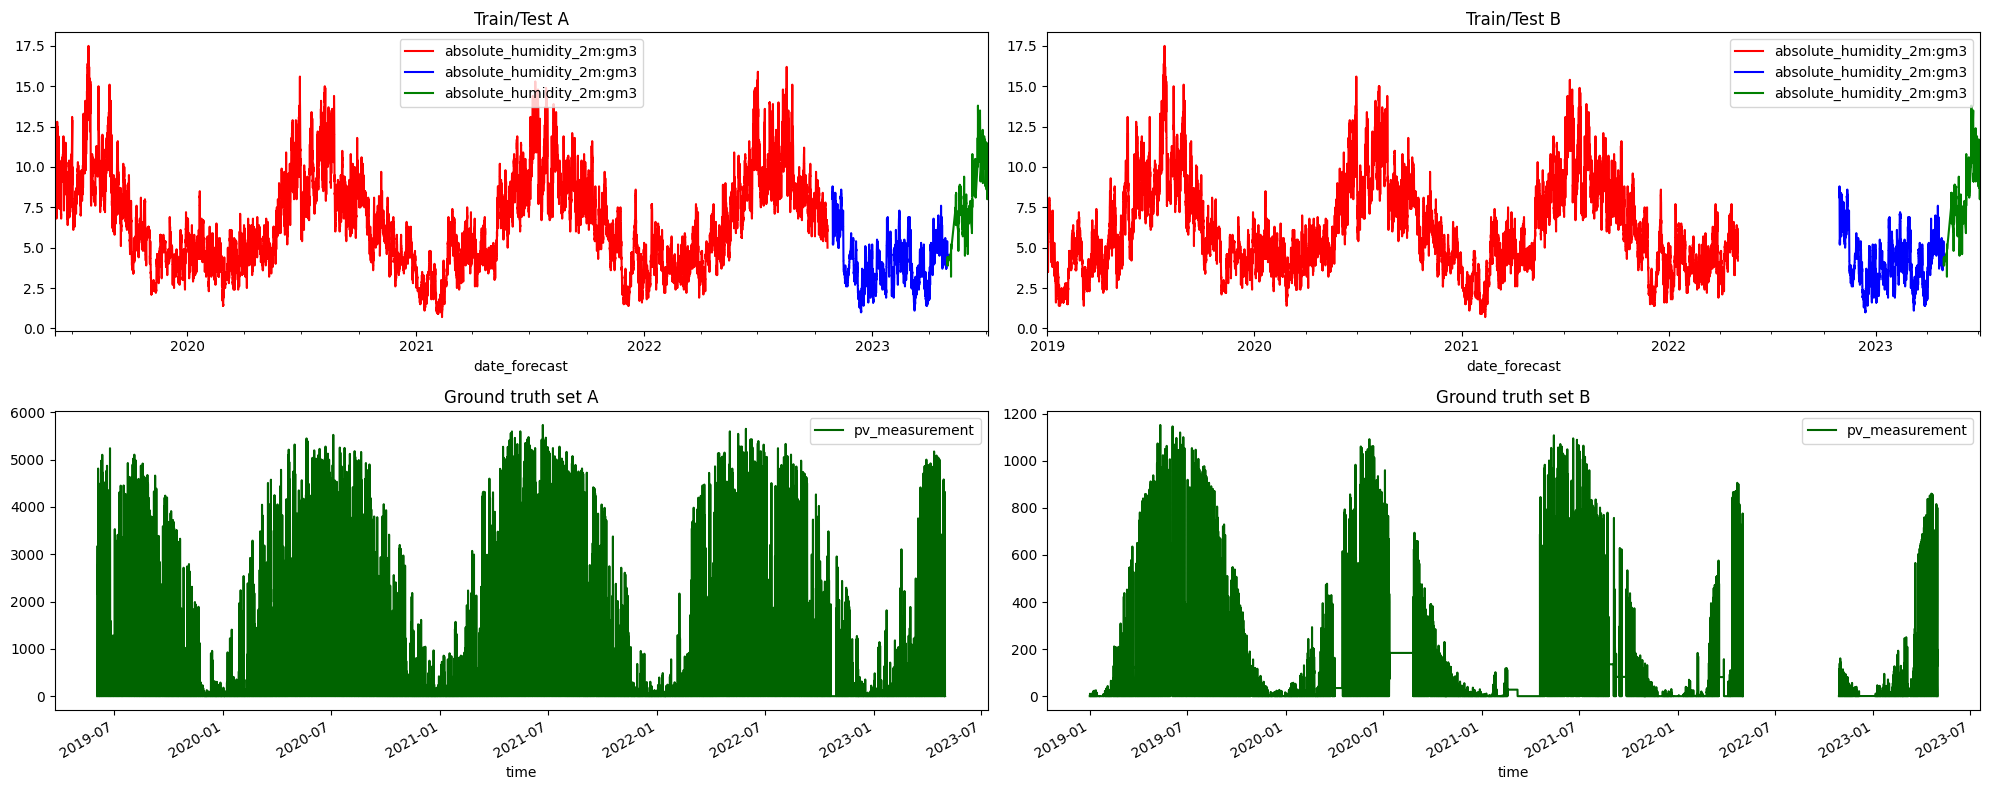

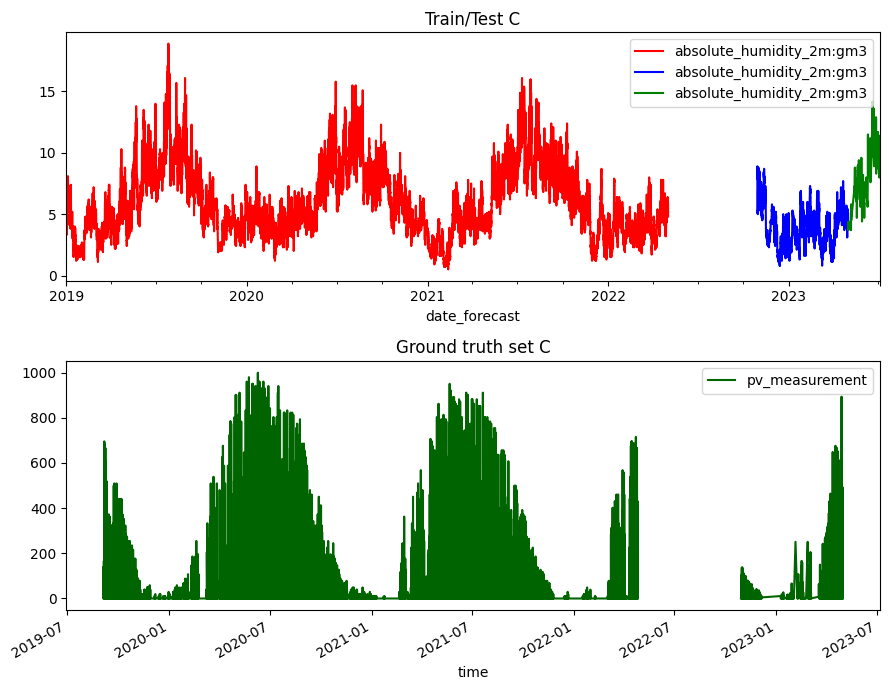

In [36]:
# Set display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Set plot options
plt.rcParams['figure.figsize'] = [20, 8]  
fig, axs = plt.subplots(2, 2)  # Adjust height ratios

# Plotting a single feature for all the sets to understand the data better
feature_name = 'absolute_humidity_2m:gm3'

# Plotting Train/Test & Ground Truth for set A
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,0], color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,0], color='green')
train_a[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1,0], title='Ground truth set A', color='darkgreen')

# Plotting Train/Test & Ground Truth for set B
X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,1], title='Train/Test B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,1], color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0,1], color='green')
train_b[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1,1], title='Ground truth set B', color='darkgreen')
plt.tight_layout()

plt.rcParams['figure.figsize'] = [9, 7]  
fig, axs = plt.subplots(2, 1)  # Adjust height ratios
# Plotting Train/Test & Ground Truth for set C
X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], color='green')
train_c[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Ground truth set C', color='darkgreen')

plt.tight_layout()

#### Find the Number of NaNs 
The function `find_nans` is designed to determine the number of NaNs present in the data.
We discovered a notably high number of NaNs upon its application, indicating that certain features are mostly empty.

To verify this, the argument `print_nans = True`. This analysis unveiled three specific features shared across the datasets: ceiling_height_agl:m, cloud_base_agl:m, and snow_density:kgm3.

In [37]:
def find_nans(df: pd.DataFrame, name: str, print_nans: bool = False):
    """
    This function is intended to find the number of NaNs in each set.
    """
    print(f'{name} number of NaNs: {df.isna().sum().sum()}')

    if print_nans:
        print(' ')
        features = df.columns.values
        for feat in features:
            nans = df[feat].isna().sum()
            if nans > 0:
                print(f'{feat} : {df[feat].isna().sum()}')
        print('\n')


print(f'\nLengt of train_*  : | A: {len(train_a)} | B: {len(train_b)} | C: {len(train_c)}')
find_nans(train_a, 'train_a')
find_nans(train_b, 'train_b')
find_nans(train_c, 'train_c')

print(f'\nLengt of X_train_observed_*  : | A: {len(X_train_observed_a)} | B: {len(X_train_observed_b)} | C: {len(X_train_observed_c)}')
find_nans(X_train_observed_a, 'X_train_observed_a')
find_nans(X_train_observed_b, 'X_train_observed_b')
find_nans(X_train_observed_c, 'X_train_observed_c')

print(f'\nLengt of X_train_estimated_*  : | A: {len(X_train_estimated_a)} | B: {len(X_train_estimated_b)} | C: {len(X_train_estimated_c)}')
find_nans(X_train_estimated_a, 'X_train_estimated_a')
find_nans(X_train_estimated_b, 'X_train_estimated_b')
find_nans(X_train_estimated_c, 'X_train_estimated_c')

print(f'\nLength of X_test_estimated_*  : | A: {len(X_test_estimated_a)} | B: {len(X_test_estimated_b)} | C: {len(X_test_estimated_c)}')
find_nans(X_test_estimated_a, 'X_test_estimated_a')
find_nans(X_test_estimated_b, 'X_test_estimated_b')
find_nans(X_test_estimated_c, 'X_test_estimated_c')

# The number of nans in the observed and estimated data might be due to some of the features beeing almost all NaN.

# Find if there are 


Lengt of train_*  : | A: 34085 | B: 32848 | C: 32155
train_a number of NaNs: 0
train_b number of NaNs: 4
train_c number of NaNs: 6060

Lengt of X_train_observed_*  : | A: 118669 | B: 116929 | C: 116825
X_train_observed_a number of NaNs: 146258
X_train_observed_b number of NaNs: 137446
X_train_observed_c number of NaNs: 136028

Lengt of X_train_estimated_*  : | A: 17576 | B: 17576 | C: 17576
X_train_estimated_a number of NaNs: 21782
X_train_estimated_b number of NaNs: 21365
X_train_estimated_c number of NaNs: 21298

Length of X_test_estimated_*  : | A: 2880 | B: 2880 | C: 2880
X_test_estimated_a number of NaNs: 3971
X_test_estimated_b number of NaNs: 3912
X_test_estimated_c number of NaNs: 4104


In [38]:
find_nans(X_train_observed_a, 'Total Nans X_train_observed_a', print_nans=True)
find_nans(X_train_observed_b, 'Total Nans X_train_observed_b', print_nans=True)
find_nans(X_train_observed_c, 'Total Nans X_train_observed_c', print_nans=True)

find_nans(X_train_estimated_a, 'Total Nans X_train_estimated_a', print_nans=True)
find_nans(X_train_estimated_b, 'Total Nans X_train_estimated_b', print_nans=True)
find_nans(X_train_estimated_c, 'Total Nans X_train_estimated_c', print_nans=True)

find_nans(X_test_estimated_a, 'Total Nans X_test_estimated_a', print_nans=True)
find_nans(X_test_estimated_b, 'Total Nans X_test_estimated_b', print_nans=True)
find_nans(X_test_estimated_c, 'Total Nans X_test_estimated_c', print_nans=True)

Total Nans X_train_observed_a number of NaNs: 146258
 
ceiling_height_agl:m : 22247
cloud_base_agl:m : 8066
snow_density:kgm3 : 115945


Total Nans X_train_observed_b number of NaNs: 137446
 
ceiling_height_agl:m : 18772
cloud_base_agl:m : 7473
snow_density:kgm3 : 111201


Total Nans X_train_observed_c number of NaNs: 136028
 
ceiling_height_agl:m : 19923
cloud_base_agl:m : 8512
snow_density:kgm3 : 107593


Total Nans X_train_estimated_a number of NaNs: 21782
 
ceiling_height_agl:m : 3919
cloud_base_agl:m : 2094
snow_density:kgm3 : 15769


Total Nans X_train_estimated_b number of NaNs: 21365
 
ceiling_height_agl:m : 3689
cloud_base_agl:m : 1963
snow_density:kgm3 : 15713


Total Nans X_train_estimated_c number of NaNs: 21298
 
ceiling_height_agl:m : 4596
cloud_base_agl:m : 2804
snow_density:kgm3 : 13898


Total Nans X_test_estimated_a number of NaNs: 3971
 
ceiling_height_agl:m : 793
cloud_base_agl:m : 298
snow_density:kgm3 : 2880


Total Nans X_test_estimated_b number of NaNs: 3912
 
c

#### Plotting Features with NaN Values for Feature Extraction
Three specific features, namely ['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3'], were plotted across all the datasets.

In the case of X_train_observed_a and X_train_estimated_a, the missing values were apparent.

However, when observing X_test_estimated_a, all three features exhibited a significantly poor representation. Consequently, the decision was made to remove these features as they were deemed unsuitable for our purpose.

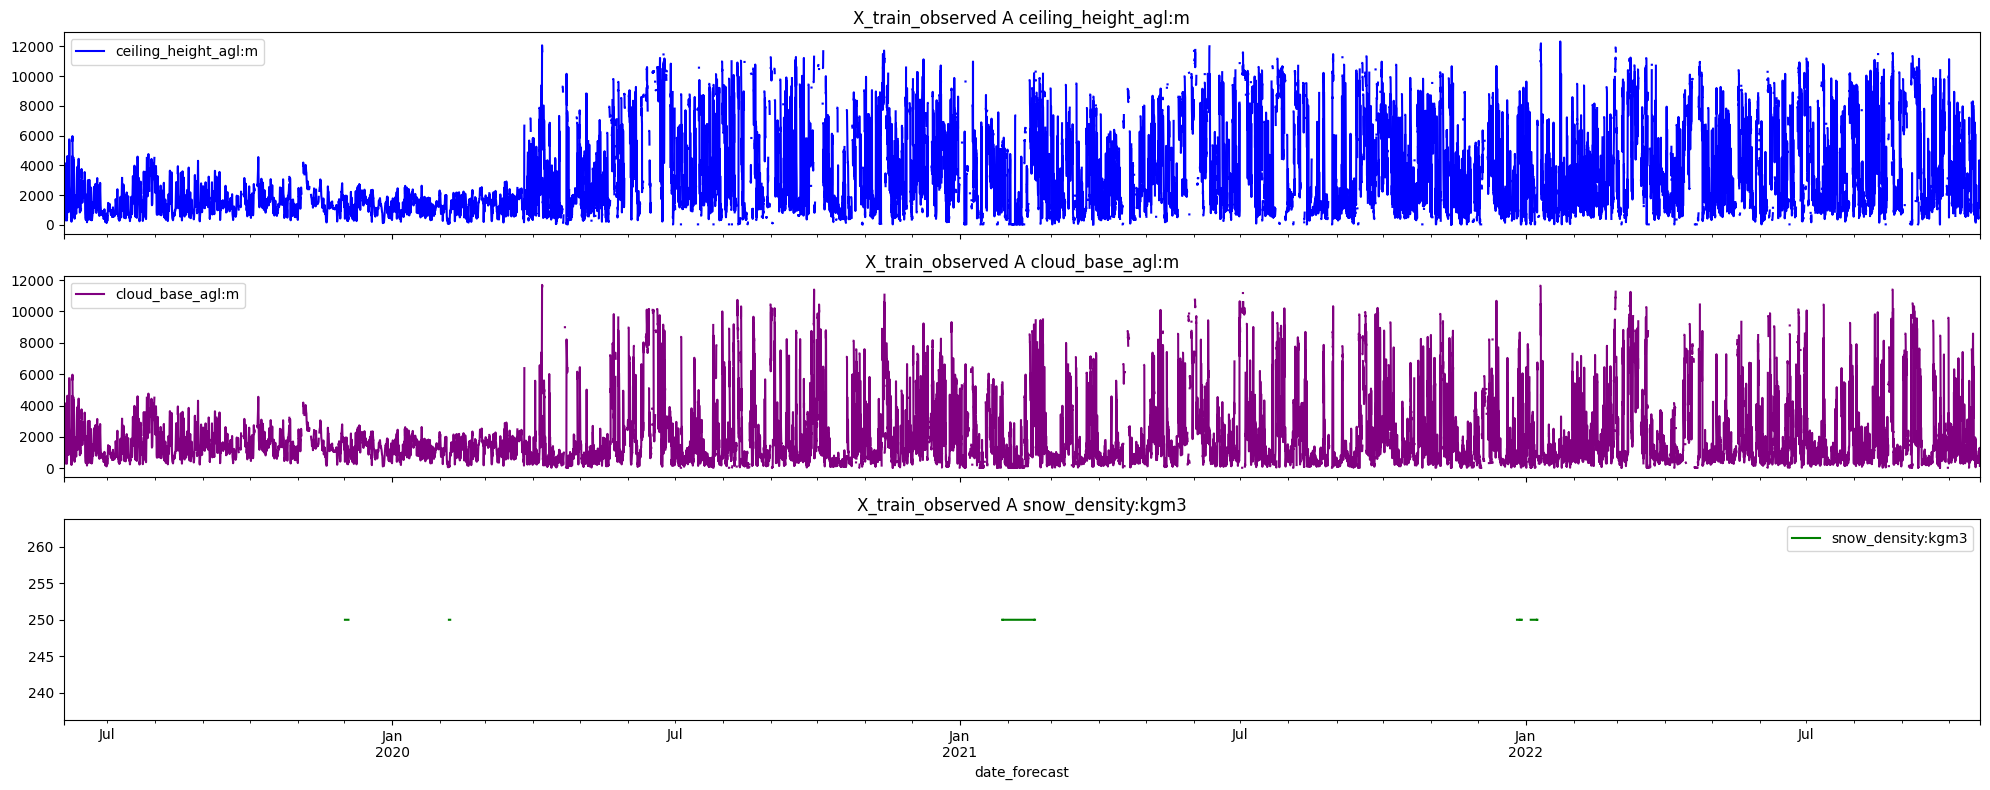

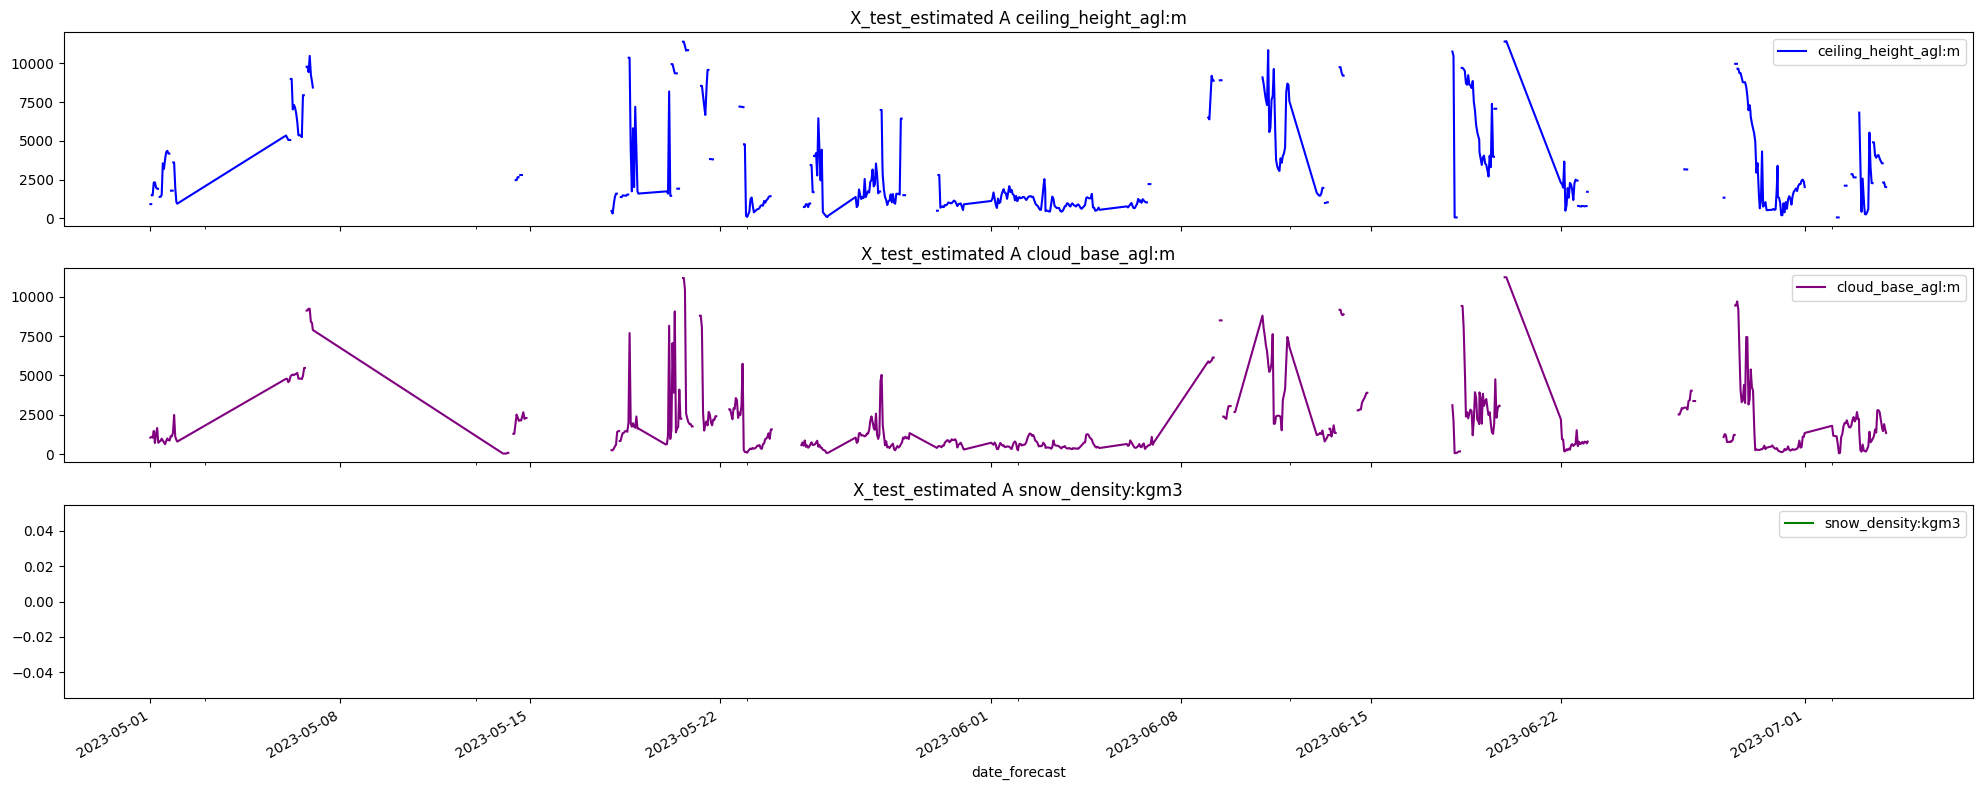

In [39]:
nan_feat = ['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3']

def feat_plot(df: pd.DataFrame, name: str, nan_feat: list):
    """
    This function is intended to plot the data for a given set.
    """
    plt.rcParams['figure.figsize'] = [20, 8]
    fig, axs = plt.subplots(3, 1, sharex=True)
    colors = ['blue', 'purple', 'green']  # Add more colors as needed

    for i, f in enumerate(nan_feat):
        df[['date_forecast', f]].set_index('date_forecast').plot(ax=axs[i], title=f'{name} {f}', color=colors[i])

    plt.tight_layout()


feat_plot(X_train_observed_a, 'X_train_observed A', nan_feat)
# feat_plot(X_train_observed_b, 'X_train_observed B', nan_feat)
# feat_plot(X_train_observed_c, 'X_train_observed C', nan_feat)

# feat_plot(X_train_estimated_a, 'X_train_estimated A', nan_feat)
# feat_plot(X_train_estimated_b, 'X_train_estimated B', nan_feat)
# feat_plot(X_train_estimated_c, 'X_train_estimated C', nan_feat)

feat_plot(X_test_estimated_a, 'X_test_estimated A', nan_feat)
# feat_plot(X_test_estimated_b, 'X_test_estimated B', nan_feat)
# feat_plot(X_test_estimated_c, 'X_test_estimated C', nan_feat)

#### Plott an exam all the features 

To plot all the features, uncomment the provided code. Summarizing the result features like: elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, prob_rime:p, snow_density:kg/m³, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, and wind_speed_w_1000hPa:m/s remain at a constant value across all the datasets. Hence, they are deemed non-contributory for the model.

In [40]:
# def file_to_df(file_path: list[str]):
#     df = pd.read_parquet(file_path)
#     return df

# def create_X_set(X_estimated, X_observed):
#     X_estimated = X_estimated.drop("date_calc", axis = 1)
#     X = pd.concat([X_observed, X_estimated], axis = 0, ignore_index=True)
#     return X

# def plot_X_sets(file_paths: list[str]):
#     buildings = ['A', 'B', 'C']
#     paths = []
    
#     for i, path in enumerate(file_paths):
#         # Retrieve data        
#         y = pd.read_parquet(path[0])
        
        
#         X_estimated = pd.read_parquet(path[1])
#         X_observed = pd.read_parquet(path[2])
#         X = create_X_set(X_estimated, X_observed)

#         X_pred = pd.read_parquet(path[3])

#         plot_features(X, buildings[i])
#         plot_features(X_pred, "Pred "+ buildings[i])  

# def plot_X_sets(file_paths: list[str]):
#     buildings = ['A', 'B', 'C']
#     paths = []
    
#     for i, path in enumerate(file_paths):
#         # Retrieve data        
#         y = pd.read_parquet(path[0])
        
        
#         X_estimated = pd.read_parquet(path[1])
#         X_observed = pd.read_parquet(path[2])
#         X = create_X_set(X_estimated, X_observed)

#         X_pred = pd.read_parquet(path[3])

#         plot_features(X, buildings[i])
#         plot_features(X_pred, "Pred "+ buildings[i])  
        
# def plot_features(X: pd.DataFrame, set: str):
#     X = X.copy()
#     # Extract necesarry values for feature generation.
#     measurements = list(X.columns.values)
#     measurements.remove("date_forecast")
#     try:
#         measurements.remove("date_calc")
#     except:
#         print("")

#     for measurement in measurements:
#         # Count NaN values
#         nan_count = X[measurement].isna().sum()
#         print("Number of NaN values in " + measurement + ":", nan_count)

#         # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line. MIGHT BE BAD FOR THE TRAINING DATA DROP USELESSNESS!
#         X[measurement] = X[measurement].fillna(0)
    
#         X[measurement].plot()
#         plt.title("Location " + set + ": " +measurement)
#         plt.show()

# file_paths = [['A/train_targets.parquet', 'A/X_train_estimated.parquet', 'A/X_train_observed.parquet', 'A/X_test_estimated.parquet'],
#               ['B/train_targets.parquet', 'B/X_train_estimated.parquet', 'B/X_train_observed.parquet', 'B/X_test_estimated.parquet'],
#               ['C/train_targets.parquet', 'C/X_train_estimated.parquet', 'C/X_train_observed.parquet', 'C/X_test_estimated.parquet']]
# plot_X_sets(file_paths) 

#### Feature Extracting 
The correlation between all the features from X and the pv_mesurment from y was also used in the analysis. The correlation was calculated with the function __`correlation_calc`__ and plotted with the function __`see_corre_bar`__. The thought behind this was that features with a high correlation with the pv_mesurment would be more useful for the model. Both for positive and negative correlation, the distinction is that positive correlation means the feature is moving in the same direction as pv_mesurment, and negative correlation means they move in the opposite direction.

It is important to note that highly correlated does not necessarily mean they are helpful for the model. A high correlation can indicate that it only correlates strongly on one point but is zero for the rest of the data sample. This theory was strengthened by plotting features with a high correlation like sow_depth:cm. This feature is almost flat the entire year and is assumed not to be crucial for the model.

It was assumed that the results for data set A would also correlate with results from the other data sets.

##### Help functions for correlation 🫧

In [41]:
# Beregn kovarians for hver funksjon med utgangsvariabelen
def correlation_calc(train, obs, features_list):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    train = train.fillna(0)
    obs = obs.fillna(0)

    correlations = {}
    for feature in features_list:
        covariance = obs[feature].corr(train['pv_measurement'])
        correlations[feature] = covariance

    # Opprett en liste med kovariansverdiene
    corr_data = []
    for feature, corl in correlations.items():
        corr_data.append([feature, corl])
    return correlations, corr_data

def see_corre_text(correlations):
    print('This is the correlation between each feature and the output variable: \n')
    corr_data = [[feature, correlation] for feature, correlation in correlations.items()]
    table = tabulate(corr_data, headers=['Feature', 'Correlation'], tablefmt='pipe')
    print(table)

def see_corre_bar(correlations):
    correlation_df = pd.DataFrame(correlations.items(), columns=['Feature', 'Correlation']) # Create df to store the correlations
    correlation_df = correlation_df.sort_values(by='Correlation', ascending=False) # Sort the DataFrame by correlation values

    # Create a bar plot to visualize the correlations
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Correlation', y='Feature', data=correlation_df, orient='h', hue='Feature', palette='viridis', legend=False)
    plt.title('Correlation between pv_measurement and Features in obs')
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.show()

##### The Correlation

In [42]:
# print(X_train_observed_a.columns.values)
cor_features = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
    'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J',
    'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
    'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
    'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
    'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_density:kgm3',
    'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
    'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
    't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']

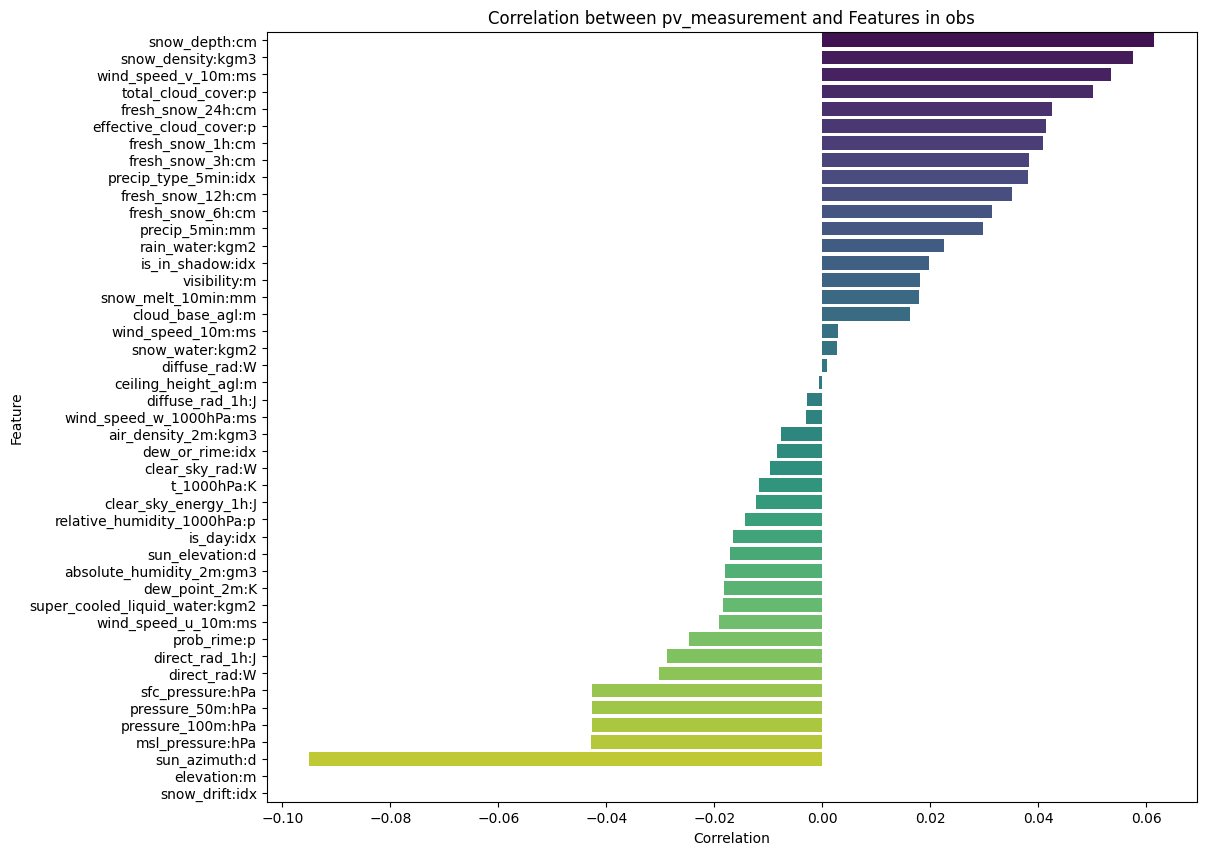

In [ ]:
tr_a, obs_a = data_length_matching(train_a, X_train_observed_a)
correlations, corr_data = correlation_calc(train_a, obs_a, cor_features)
see_corre_bar(correlations)

#### Feature selection with VarianceThreshold
Feature engineering was tried using `Variance Threshold, ` which removes all features whose variance does not meet the specified threshold. By default, it removes all zero-variance features, i.e., features with the same value in all samples.

Scikit-learn's `SelectKBest` feature selection method works by evaluating and selecting the top k features most relevant to the target variable.

The results for both methods were relatively poor. Some of the features suggested to be removed are highly useful, like is_day:idx and sun_azimuth:d.

In [ ]:
X_tr_est_a = X_train_estimated_a.drop(["date_calc"],axis=1)

def dt64_to_float(dt64):
     year = dt64.astype('M8[Y]')
     days = (dt64 - year).astype('timedelta64[D]')
     year_next = year + np.timedelta64(1, 'Y')
     days_of_year = (year_next.astype('M8[D]') - year.astype('M8[D]')).astype('timedelta64[D]')
     dt_float = 1970 + year.astype(float) + days / (days_of_year)
     return dt_float

# If changing original variable -- only run once
X_total = pd.concat([X_tr_est_a, X_train_observed_a], axis = 0)
X_total = X_total.reset_index(drop=True)
X_total = X_total.dropna()
y, X = data_length_matching(train_a, X_total)
X['date_forecast'] = dt64_to_float(X['date_forecast'].to_numpy())

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

# Get the mask of selected features (True for selected, False for removed)
selected_features_mask = sel.get_support()

# Get the names of removed features
removed_features_try1 = [feature for feature, keep in zip(X.columns, selected_features_mask) if not keep]

# Print the names of removed features
print("Removed features:", removed_features_try1)

Removed features: ['air_density_2m:kgm3', 'dew_or_rime:idx', 'elevation:m', 'fresh_snow_1h:cm', 'precip_5min:mm', 'rain_water:kgm2', 'snow_density:kgm3', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'super_cooled_liquid_water:kgm2', 'wind_speed_w_1000hPa:ms']


#### Univariate feature selection with SelectKBest
With all the features except the three features with NaN.

In [ ]:
X = X.drop(['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3'] , axis=1)
y = y['pv_measurement'].ravel()

X_new_all = SelectKBest(f_regression, k=5).fit_transform(X, y)

# Fit the SelectKBest method and transform the data
selector = SelectKBest(f_regression, k = 5)
X_new_all = selector.fit_transform(X, y)

# Get the mask of selected features (True for selected, False for removed)
selected_features_mask = selector.get_support()

# Get the names of removed features
removed_features_try2 = [feature for feature, keep in zip(X.columns, ~selected_features_mask)]

# Print the names of removed features
print("Removed features:", removed_features_try2)

Removed features: ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']


In [ ]:
# Convert the lists to sets for easier comparison
set1 = set(removed_features_try1)
set2 = set(removed_features_try2)

# Find the differences between lists
diff_set1_2 = set1.symmetric_difference(set2)

# Print the differences and indicate which list they belong to
print("Features in try1 and not in try2:", diff_set1_2, "in try1")

Features in try1 and not in try2: {'is_day:idx', 'precip_type_5min:idx', 'fresh_snow_12h:cm', 'fresh_snow_6h:cm', 'prob_rime:p', 'sfc_pressure:hPa', 'wind_speed_u_10m:ms', 'relative_humidity_1000hPa:p', 'direct_rad:W', 'dew_point_2m:K', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'total_cloud_cover:p', 'diffuse_rad_1h:J', 'snow_density:kgm3', 'msl_pressure:hPa', 'diffuse_rad:W', 'snow_depth:cm', 'sun_elevation:d', 'pressure_100m:hPa', 't_1000hPa:K', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'date_forecast', 'clear_sky_rad:W', 'pressure_50m:hPa', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3', 'sun_azimuth:d', 'clear_sky_energy_1h:J', 'wind_speed_v_10m:ms'} in try1


### Feature Extraction -- Isaks del

In [ ]:
def square_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]):
    squared_df = pd.DataFrame()
    df = df.copy()
    for measurement in measurements:
        # Calculate derivative estimates
        squared_df['squared_' + measurement + '_2'] = df[measurement]**2
    return squared_df

def upscale_(df: pd.DataFrame, feature: str, upscale: int) -> pd.DataFrame:
    df = df.copy()
    upscale_df = pd.DataFrame()
    
    upscale_df["uscale_" + feature] = df[feature]*upscale

    return upscale_df

def dot_df(df: pd.DataFrame, dot_feature: str, features: list[str]) -> pd.DataFrame:
    df = df.copy()
    dot_df = pd.DataFrame()

    for feature in features:
        dot_df[dot_feature + '_dot_' + feature] = df[dot_feature] * df[feature]

    return dot_df

def log_df(df: pd.DataFrame, features: list[str]):
    
    df = df.copy()
    log_df = pd.DataFrame()

    for feature in features:
        df[feature] = abs(df[feature])
        df[feature] = df[feature] + 1
        log_df['log_' + feature] =  np.log(df[feature])

    return log_df


def difference_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """
    der_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    for measurement in measurements:
        # Calculate derivative estimates
        der_df['derivative_' + measurement + '_d'] = df[measurement].diff()
    
    df = df.drop('time_diff', axis =  1)

    # Since the first element will result in a NaN, we must backfill this one.
    der_df = der_df.interpolate(method='linear')
    der_df = der_df.bfill()
    
    return der_df

def double_derivative_from_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """
    dder_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    # Calculate derivative estimates
    for measurement in measurements:
        dder_df['double_derivative_' + measurement + '_dd'] = df[measurement].diff() / (divmod(df['time_diff'].dt.total_seconds(), 60)[0]**2)
    
    df = df.drop('time_diff', axis=1)
    
    # Since the first element will result in a NaN, we must backfill this one.
    dder_df = dder_df.interpolate(method='linear')
    dder_df = dder_df.bfill()

    return dder_df

def daily_accumulated_val_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    
    i_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps)

    # Create a new column for the date
    df['date'] = df[timeStamps].dt.date

    for measurement in measurements:
        # Calculate the integral value for each day
        i_df['integral_' + measurement + '_integral'] = df.groupby('date')[measurement].cumsum()
    
    df = df.drop('date', axis=1)

    return i_df

def daily_accumulated_val_squared_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    
    di_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps)

    # Create a new column for the date
    df['date'] = df[timeStamps].dt.date

    for measurement in measurements:
        # Calculate the integral value for each day
        di_df['double_integral_' + measurement + '_dintegral'] = df.groupby('date')[measurement].cumsum()**2
    
    df = df.drop('date', axis=1)

    return di_df

def time_data_from_df(df: pd.DataFrame, timestamps: str) -> pd.DataFrame: 
    # Extracting components
    time_df = pd.DataFrame()
    df = df.copy()
    time_df['day_of_year:day'] = df[timestamps].dt.dayofyear
    time_df['month:month'] = df[timestamps].dt.month
    #time_df['year:year'] = df[timestamps].dt.year
    time_df['hour:hour'] = df[timestamps].dt.hour
    return time_df


# Should modify this
def n_largest_freq(df: pd.DataFrame, measurements: list[str], n_largest: int):
    """
    Generates values based on the largest frequencies that are present.
    """
    df = df.copy()
    freq_df = pd.DataFrame()

    for measurement in measurements:
        signal = df[measurement].values

        fft_result = np.fft.fft(signal)
        
        
        indices = np.argsort(np.abs(fft_result))[::-1][:n_largest]

        for i, idx in enumerate(indices):
            # Set all other frequency components to zero
            fft_result_filtered = np.zeros_like(fft_result)
            fft_result_filtered[idx] = fft_result[idx]

            # Compute IFFT
            ifft_result = np.fft.ifft(fft_result_filtered)

            # Add the filtered results to the dataframe
            freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real


    return freq_df

def freq_comb(df: pd.DataFrame, features: list[str]) -> np.array:
    """
    Takes the fourier transform of multiple signals add them together, and then takes the inverse.

    features: Are what you would like to combine.
    df: Chosen dataframe containing feature information.
    """

    total_fft = 0
    
    for feat in features:
        # Finding the signal directly might be wrong due to timestamps and such, but might still be helpful. It is not correct, but improvements like day by day sampling might be useful.
        signal = df[feat].values

        # Min-max scaling
        scaled_signal = min_max_scale(signal)
        
        fft = np.fft.fft(scaled_signal)
        total_fft = total_fft + fft
    
    ifft_result = np.fft.ifft(total_fft)

    return ifft_result.real

def min_max_scale(signal: np.array) -> np.array:
    # Calculate min and max values
    min_val = np.min(signal)
    max_val = np.max(signal)

    # Min-max scaling
    scaled_signal = (signal - min_val) / (max_val - min_val)

    return scaled_signal

def shifted_values_24_h(y: pd.DataFrame, measurement: str)->pd.DataFrame:
    df = pd.DataFrame()
    for i in range(1, 25):
        df[measurement + 'n-' + str(i)] = y[measurement].shift(i)
    
    return df

def merge_features(df: pd.DataFrame):
    # Extract the part before ":" in column names
    df.columns = df.columns.str.split(':').str[0]

    # Group by modified column names and sum values
    grouped_df = df.groupby(df.columns, axis=1).sum()

    return grouped_df

def duplicates(df: pd.DataFrame)->None:
    df = df.copy()
    # Assuming df is your DataFrame and 'column_name' is the column you're interested in
    duplicate_counts = df['pv_measurement'].value_counts()
    duplicate_counts = duplicate_counts[duplicate_counts > 1]

    print(duplicate_counts)

def remove_double_entries(y: pd.DataFrame) -> pd.DataFrame:
    # Assuming df is your DataFrame and 'column_name' is the column you're interested in
    df = y.copy()
    mask = (df['pv_measurement'] != df['pv_measurement'].shift()) | (df['pv_measurement'] == 0)
    filtered_df = df[mask]
    return filtered_df


In [ ]:
"""
A couple of functions to generate the approprate features for both training and prediction data.
"""

def train_data_processing(X: pd.DataFrame, y: pd.DataFrame, filter_list: list[str] = [], months: list[int] = [], feedback: bool = False):
   
    # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line. MIGHT BE BAD FOR THE TRAINING DATA DROP USELESSNESS!
    X = X.interpolate(method='linear', limit_direction = "both")

    # Extract necesarry values for feature generation.
    timestamps = "date_forecast"
    measurements = list(X.columns.values)
    
    measurements.remove(timestamps)
    # print(measurements)

    # Probable features that may be used
    squared_df = square_df(X, timestamps, measurements)
    # print("Squared")
    # print(squared_df.columns.values)
    
    der_df = difference_df(X, timestamps, measurements)
    # print("Derivative")
    # print(der_df.columns.values)
    
    dder_df = double_derivative_from_df(X, timestamps, measurements)
    # print("Double Derivative")
    # print(dder_df.columns.values)
    
    int_df = daily_accumulated_val_df(X, timestamps, measurements)
    # print("Integral")
    # print(int_df.columns.values)
    
    dint_df = daily_accumulated_val_squared_df(X, timestamps, measurements)
    # print("Double Integral")
    # print(dint_df.columns.values)
    
    l_df = log_df(X, measurements)
    # print("Log")
    # print(l_df.columns.values)
    
    dotted_df = dot_df(X, 'direct_rad:W', measurements)
    # print("Dotted")
    # print(dotted_df.columns.values)

    n_largest_freq_df =  n_largest_freq(X, measurements, n_largest = 5)
    # print("N-largest")
    # print(n_largest_freq_df.columns.values)
    
    time_df = time_data_from_df(X, timestamps)
    # print("Time")
    # print(time_df.columns.values)

    X = pd.concat([X, squared_df, der_df, dder_df, dint_df, int_df, l_df, dotted_df, n_largest_freq_df, time_df], axis = "columns")
    
    if len(months) > 0:
        X =  X[X['date_forecast'].dt.month.isin(months)]

    if len(filter_list) > 0:
        X = X[filter_list + ["date_forecast"]]

    # Additional features
    duplicates(y)
    y = remove_double_entries(y)
    #der_y = difference_df(y, "time", ["pv_measurement"])
    # der_y_shifted = shifted_values_24_h(der_y, "derivative_pv_measurement_d")
    y_shifted =  shifted_values_24_h(y, "pv_measurement")
    y.reset_index(drop = True)
    y_shifted.reset_index(drop = True)
    # Adding together the added features to one dataframe.
    y_BIG = pd.concat([y, y_shifted])
    X.reset_index(drop = True)

    # Making sure that the two dataframes match in length.
    y_BIG, X = data_length_matching(y_BIG, X)

    # Get our desired output
    y = y_BIG["pv_measurement"]
   
    
    if feedback:
        # Removing datetime object column.
        y_features = y_BIG.drop('pv_measurement', axis=1)
        y_features = y_features.drop('time', axis=1)
        y_features = y_features.reset_index(drop = True)
        
        
        y_features = y_features.reset_index(drop = True)
        X = X.reset_index(drop = True)
        X = pd.concat([X, y_features], axis = 1)
        
    
    # Removing datetime object column
    X = X.drop(timestamps, axis=1)
    
    X = X.reset_index(drop = True)

    return X, y

def pred_data_processing(X_pred: pd.DataFrame) -> pd.DataFrame:
    """
    A function that reads
    """
    
    # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
    X_pred = X_pred.interpolate(method = 'linear')
    X_pred = X_pred.bfill()

    # Extract necesarry values for feature generation.
    timestamps = "date_forecast"

    # Removing date-time from measurements
    measurements = list(X_pred.columns.values)
    measurements.remove("date_forecast")
    measurements.remove("date_calc")

    # Probable features that may be used
    squared_df = square_df(X_pred, timestamps, measurements)
    der_df = difference_df(X_pred, timestamps, measurements)
    dder_df = double_derivative_from_df(X_pred, timestamps, measurements)
    int_df = daily_accumulated_val_df(X_pred, timestamps, measurements)
    dint_df = daily_accumulated_val_squared_df(X_pred, timestamps, measurements)
    l_df = log_df(X_pred, measurements)
    dotted_df = dot_df(X_pred, 'direct_rad:W', measurements)
    time_df = time_data_from_df(X_pred, timestamps)
    n_largest_freq_df =  n_largest_freq(X_pred, measurements, n_largest = 5)

    X_pred_new = pd.concat([X_pred, squared_df, der_df, dder_df, dint_df, int_df, l_df, dotted_df, n_largest_freq_df, time_df], axis = "columns")

    X_pred_new = X_pred_new.drop("date_calc", axis = 1)
    return X_pred_new


In [ ]:
def create_training_and_pred_data(file_paths: list[str], months: list[int] = []):
    buildings = ['A', 'B', 'C']
    paths = []
    
    for i, path in enumerate(file_paths):
        # Retrieve data        
        y = pd.read_parquet(path[0])
        X_estimated = pd.read_parquet(path[1])
        X_observed = pd.read_parquet(path[2])
        X_pred = pd.read_parquet(path[3])

        # Processing and cleaning data
        y = y.dropna()
        X_estimated = X_estimated.drop("date_calc", axis = 1)
        X = pd.concat([X_observed, X_estimated], axis = 0, ignore_index=True)
        
        X, y= train_data_processing(X, y, months=months)
        


        X_pred = pred_data_processing(X_pred)
        
        X_path = buildings[i] + "/" + "X.csv"
        X.to_csv(path_or_buf = X_path, sep='\t')

        y_path = buildings[i] + "/" + "y.csv"
        y.to_csv(path_or_buf = y_path, sep='\t')

        X_pred_path = buildings[i] + "/" + "X_pred.csv"
        X_pred.to_csv(path_or_buf = X_pred_path, sep='\t')
        
        
        paths.append([X_path, y_path, X_pred_path])

    return paths 

def n_smallest(df: pd.DataFrame, column: str, N: int = 10) -> list[float]:
    # Assuming df is your DataFrame and column_name is the column you're interested in
    filtered_df = df[df[column] >= 10]

    # Replace N with the number of lowest non-zero values you want
    
    result = filtered_df.nsmallest(N, column)
    return result

def n_highest(df: pd.DataFrame, column: str, N: int = 10) -> list[float]:
    # Replace N with the number of largest non-zero values you want
    N = 10
    result = df.nlargest(N, column)
    return list(result)




In [50]:
file_paths = [['A/train_targets.parquet', 'A/X_train_estimated.parquet', 'A/X_train_observed.parquet', 'A/X_test_estimated.parquet'],
              ['B/train_targets.parquet', 'B/X_train_estimated.parquet', 'B/X_train_observed.parquet', 'B/X_test_estimated.parquet'],
              ['C/train_targets.parquet', 'C/X_train_estimated.parquet', 'C/X_train_observed.parquet', 'C/X_test_estimated.parquet']]

file_paths = create_training_and_pred_data(file_paths = file_paths, months = [5, 6, 7, 8])


C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

pv_measurement
0.00       16040
0.22         128
0.44          81
0.66          63
1.10          53
           ...  
814.66         2
485.98         2
656.70         2
275.66         2
3985.74        2
Name: count, Length: 3478, dtype: int64


C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

pv_measurement
0.0000       17312
183.7125      1076
27.6000        493
34.5000        406
81.9375        369
             ...  
825.4125         2
609.7875         2
910.8000         2
461.4375         2
1004.8125        2
Name: count, Length: 1052, dtype: int64


C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

pv_measurement
0.00      15952
9.80        998
19.60       588
29.40       479
39.20       401
          ...  
169.54        2
265.58        2
226.38        2
150.92        2
208.74        2
Name: count, Length: 259, dtype: int64


C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real
C:\Users\amand\AppData\Local\Temp\ipykernel_27988\3830452334.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

## Max Value of Day
Predicts when a max value occurs during a day. This to put it simply did not work. It had incredibly poor predictions for all datasets.

In [51]:
# Creates a max indication, and may be used to generate additional features
def max_day_df(y: pd.DataFrame)-> pd.DataFrame:
    y = y.copy()
    df = pd.DataFrame()
    # Group by day and find the max measurement for each day
    y['date'] = y['time'].dt.date 
    df['pv_measurement']  = np.where(y['pv_measurement'] == y.groupby('date')['pv_measurement'].transform('max'), 1, 0)
    df['time'] = y['time']
    return df



In [52]:
# def train_data_processing(X: pd.DataFrame, y: pd.DataFrame, filter_list: list[str] = [], add_feedback: bool = False):
   
#     # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
#     X = X.interpolate(method='linear', limit_direction = "both")

#     # Extract necesarry values for feature generation.
#     timestamps = "date_forecast"
#     measurements = list(X.columns.values)
#     measurements.remove(timestamps)

#     # Probable features that may be used
#     squared_df = square_df(X, timestamps, measurements)
#     der_df = difference_df(X, timestamps, measurements)
#     dder_df = double_derivative_from_df(X, timestamps, measurements)
#     int_df = daily_accumulated_val_df(X, timestamps, measurements)
#     dint_df = daily_accumulated_val_squared_df(X, timestamps, measurements)
#     time_df = time_data_from_df(X, timestamps)

#     X = pd.concat([X, squared_df, der_df, dder_df, dint_df, int_df, time_df], axis = "columns")

#     if len(filter_list) > 0:
#         X = X[filter_list + ["date_forecast"]]

#     # Additional features
#     der_y = difference_df(y, "time", ["pv_measurement"])
#     der_y_shifted = shifted_values_24_h(der_y, "derivative_pv_measurement_d")
#     y_shifted =  shifted_values_24_h(y, "pv_measurement")

#     # Adding together the added features to one dataframe.
#     y_BIG = pd.concat([y, der_y_shifted, y_shifted])


#     # Making sure that the two dataframes match in length.
#     y_BIG, X = data_length_matching(y_BIG, X)

#     # Get our desired output
#     y = y_BIG["pv_measurement"]
#     y = y.reset_index(drop = True)
    
    
#     if add_feedback:
#         # Removing datetime object column.
#         y_features = y_BIG.drop('pv_measurement', axis=1)
#         y_features = y_features.drop('time', axis=1)
#         y_features = y_features.reset_index(drop = True)

#         X = pd.concat([X, y_features], axis = 1)
    
#     # Removing datetime object column
#     X = X.drop(timestamps, axis=1)
#     X = X.reset_index(drop = True)

#     return X, y

# def pred_data_processing(X_pred: pd.DataFrame, filter_list: list[str] = []) -> pd.DataFrame:
#     """
#     A function that reads
#     """
    
#     # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
#     X_pred = X_pred.interpolate(method = 'linear')
#     X_pred = X_pred.bfill()

#     # Extract necesarry values for feature generation.
#     timestamps = "date_forecast"

#     # Removing date-time from measurements
#     measurements = list(X_pred.columns.values)
#     measurements.remove("date_forecast")
#     measurements.remove("date_calc")

#     # Probable features that may be used
#     squared_df = square_df(X_pred, timestamps, measurements)
#     der_df = difference_df(X_pred, timestamps, measurements)
#     dder_df = double_derivative_from_df(X_pred, timestamps, measurements)
#     int_df = daily_accumulated_val_df(X_pred, timestamps, measurements)
#     dint_df = daily_accumulated_val_squared_df(X_pred, timestamps, measurements)
#     time_df = time_data_from_df(X_pred, timestamps)

    

#     X_pred_new = pd.concat([X_pred, squared_df, der_df, dder_df, dint_df, int_df, time_df], axis = "columns")

#     if len(filter_list) > 0:
#         X_pred_new = X_pred_new[filter_list + ['date_forecast']]
#     else:
#         X_pred_new = X_pred_new.drop("date_calc", axis = 1)

#     return X_pred_new

# class feature_learner:
#     def __init__(self, file_paths: list[list[str]], features: list[str] = [], save_folder: str = "") -> None:
#         self.file_paths = file_paths
#         self.features = features
#         self.save_folder = save_folder + "/"
#         self.buildings = ["A", "B", "C"]

#     def create_training_data_multi_model(self):
#         self.X_train_sets = []
#         self.X_test_sets = []
#         self.y_train_sets = []
#         self.y_test_sets = []
#         self.X_pred_sets = []

#         for i, path in enumerate(self.file_paths):
            
#             y = pd.read_parquet(path[0])
#             X_estimated = pd.read_parquet(path[1])
#             X_observed = pd.read_parquet(path[2])
#             X_pred = pd.read_parquet(path[3])

#             # =================  TEST DATA  ================
#             X_pred = pred_data_processing(X_pred, self.features)
#             X_pred['building'] = i

#             # =================TRAINING DATA================
#             # Pre-process data
#             y = y.dropna()
#             X_estimated = X_estimated.drop("date_calc", axis = 1)
#             X = pd.concat([X_observed, X_estimated], axis = 0, ignore_index=True)
            
#             y = max_day_df(y)

#             # ================= ENSURING DATA LENGTH MATCHES ==================
#             X, y= train_data_processing(X, y, self.features)
            
            
#             # ================= ADD BUILDING FEATURE ================
#             X['building'] = i

#             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

#             # ================= SAVING ALL SETS ======================
#             self.X_train_sets.append(X_train)
#             self.X_test_sets.append(X_test)
#             self.y_train_sets.append(y_train)
#             self.y_test_sets.append(y_test)
#             self.X_pred_sets.append(X_pred)
        
#     def fit_multi_model(self):
        
#         self.models = []

#         for i in range(len(self.X_train_sets)): 
            
#             train_dataset = cb.Pool(self.X_train_sets[i], self.y_train_sets[i])

#             model = cb.CatBoostClassifier(loss_function="Logloss", logging_level='Silent')

#             grid = {'iterations': [100, 150, 200],
#                     'learning_rate': [0.03, 0.1],
#                     'depth': [2, 4, 6, 8],
#                     'l2_leaf_reg': [0.2, 0.5, 1, 3]}
#             model.grid_search(grid, train_dataset, verbose=False)

#             self.models.append(model)

#     def predict_multi_model(self):
#         preds = []
        
#         for i in range(len(self.X_pred_sets)):
#             X_pred = self.X_pred_sets[i].drop('date_forecast', axis = 1)
#             unformated_pred = self.models[i].predict(X_pred)
            
#             unformated_pred_df = pd.DataFrame()
#             unformated_pred_df["date_forecast"] = self.X_pred_sets[i]["date_forecast"]
#             unformated_pred_df["building"] = self.X_pred_sets[i]["building"]

#             replace_dict = {0: 'A', 1: 'B', 2: 'C'}

#             # Use the replace method with the specified column and dictionary
#             unformated_pred_df["building"] = unformated_pred_df["building"].replace(replace_dict)
#             unformated_pred_df["pv_measurement"] = pd.Series(unformated_pred)
            
#             unformated_pred_df.to_csv(self.buildings[i] + "max_pred" + ".csv")

#     def get_performance_multi_model(self) -> None:
        
#         for i in range(len(self.X_test_sets)):
#             pred = self.models[i].predict(self.X_test_sets[i])
#             accuracy = accuracy_score(self.y_test_sets[i], pred)
#             print("SCORE BUILDING " + self.buildings[i])
#             print(f"Accuracy: {accuracy}")

# file_paths = [['A/train_targets.parquet', 'A/X_train_estimated.parquet', 'A/X_train_observed.parquet', 'A/X_test_estimated.parquet'],
#               ['B/train_targets.parquet', 'B/X_train_estimated.parquet', 'B/X_train_observed.parquet', 'B/X_test_estimated.parquet'],
#               ['C/train_targets.parquet', 'C/X_train_estimated.parquet', 'C/X_train_observed.parquet', 'C/X_test_estimated.parquet']]


# features = ["absolute_humidity_2m:gm3", "air_density_2m:kgm3", "ceiling_height_agl:m", "clear_sky_energy_1h:J", 
#            "clear_sky_rad:W", "diffuse_rad:W", "diffuse_rad_1h:J", 
#            "direct_rad:W", "direct_rad_1h:J", "effective_cloud_cover:p", "msl_pressure:hPa", "prob_rime:p", "rain_water:kgm2", "relative_humidity_1000hPa:p",
#            "sun_azimuth:d", "sun_elevation:d", "super_cooled_liquid_water:kgm2", "t_1000hPa:K", "total_cloud_cover:p", 'day_of_year:day', 'month:month', 'hour:hour']


# # Testing the procedure 
# l = feature_learner(file_paths = file_paths, features = features)
# l.create_training_data_multi_model()
# l.fit_multi_model()
# l.get_performance_multi_model()
# l.predict_multi_model()



## Machine Learning Pipeline
Testing different Machine Learning models, and tuning and adjusting features quickly becomes a bother if one does not create helper function and classes. The code bellow is what the Project Group developed during the project. 

In [53]:
file_paths = [["A/X.csv", "A/y.csv", "A/X_pred.csv"],
              ["B/X.csv", "B/y.csv", "B/X_pred.csv"],
              ["C/X.csv", "C/y.csv", "C/X_pred.csv"]]

In [54]:
"""
A class to organize the different steps in the machine learning pipeline. The class contains some nice helper functions
that helps the user gain insight into what features the model finds the most usefull.
"""


class learner:
    def __init__(self, file_paths: list[list[str]], features: list[str] = [], save_folder: str = "", feedback: bool = False) -> None:
        self.file_paths = file_paths
        self.features = features
        self.save_folder = save_folder + "/"
        self.buildings = ["A", "B", "C"]
        self.feedback = feedback

    def create_training_data_multi_model(self):
        self.X_train_sets = []
        self.X_test_sets = []
        self.y_train_sets = []
        self.y_test_sets = []
        self.X_pred_sets = []
        self.y_sets = []

        for i, path in enumerate(self.file_paths):
            
            X = pd.read_csv(path[0], sep='\t')[self.features]
            
            y = pd.read_csv(path[1], sep='\t')['pv_measurement']

            X_pred = pd.read_csv(path[2], sep='\t')[self.features + ["date_forecast"]]
            X_pred["date_forecast"] = pd.to_datetime(X_pred["date_forecast"])
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
            

            # ================= SAVING ALL SETS ======================
            self.X_train_sets.append(X_train)
            self.X_test_sets.append(X_test)
            self.y_train_sets.append(y_train)
            self.y_test_sets.append(y_test)
            self.X_pred_sets.append(X_pred)
            self.y_sets.append(y)
            


    def create_training_data(self):
        list_y = []
        list_X = []
        list_X_pred = []
        scalers = []
    
        for i, path in enumerate(self.file_paths):
            
            X = pd.read_csv(path[0], sep='\t')[self.features]
            y = pd.read_csv(path[1], sep='\t')['pv_measurement']
            X_pred = pd.read_csv(path[2], sep='\t')[self.features + ["date_forecast"]]
            X_pred["date_forecast"] = pd.to_datetime(X_pred["date_forecast"])

            y.plot()
            plt.show()
            # =================  TEST DATA  ================
            X_pred['building'] = self.buildings[i]
            
            list_X_pred.append(X_pred)

            # =================TRAINING DATA================
            
            # ADD A FUNCTION TO GENERATE BUILDING FEATURE.
            X['building'] = self.buildings[i]

            list_y.append(y)
            list_X.append(X)

        self.scalers = scalers
        # Add all the lists together. However there is a need to add set
        y = pd.concat(list_y, axis= 0, ignore_index=True)
        X = pd.concat(list_X, axis= 0, ignore_index=True)
        X_pred = pd.concat(list_X_pred, axis = 0, ignore_index=True)
        
        X = X.reset_index(drop=True)
        X_pred = X_pred.reset_index(drop=True)

        
        X_train, X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
        
        
        self.X_train, self.X_test, self.X_pred = X_train, X_test, X_pred
    
    def fit_multi_model_h2o(self):
        
        h2o.init()
        self.models = []
        
        for i in range(len(self.X_train_sets)):
            train_frame =  pd.concat([self.X_train_sets[i], self.y_train_sets[i]], axis = "columns")
            h2o_frame = h2o.H2OFrame(train_frame)

            x_train_columns = h2o_frame.columns

            model = H2OAutoML(sort_metric='MAE', max_models=10, exclude_algos=["DeepLearning"])

            model.train(x = x_train_columns, y = "pv_measurement", training_frame=h2o_frame)
            self.models.append(model)


    def fit_multi_model(self):
        
        self.models = []

        for i in range(len(self.X_train_sets)): 
            
            train_dataset = cb.Pool(self.X_train_sets[i], self.y_train_sets[i])

            model = cb.CatBoostRegressor(loss_function="MAE", logging_level='Silent')

            grid = {'iterations': [100, 150, 200],
                    'learning_rate': [0.03, 0.1],
                    'depth': [2, 4, 6, 8],
                    'l2_leaf_reg': [0.2, 0.5, 1, 3]}
            model.grid_search(grid, train_dataset, verbose=False)

            self.models.append(model)
        return self.models


    def get_performance_multi_model_h2o(self):
        mae_sum = 0

        for i in range(len(self.X_test_sets)):
            h2o_frame = h2o.H2OFrame(self.X_test_sets[i])

            pred_h2o_frame = self.models[i].predict(h2o_frame)
            pred_df = pred_h2o_frame.as_data_frame()
            pred = pred_df['predict'].to_list()
            mae = (mean_absolute_error(self.y_test_sets[i], np.array(pred)))
            mae_sum = mae + mae_sum

        print("MAE: ", mae_sum)

    def predict_multi_model_h2o(self):
        preds = []
        
        for i in range(len(self.X_pred_sets)):
            h2o_frame = h2o.H2OFrame(self.X_pred_sets[i])

            pred_h2o_frame = self.models[i].predict(h2o_frame)
            pred_df = pred_h2o_frame.as_data_frame()
            X_pred = pred_df['predict'].to_list()
            
            unformated_pred = np.array(X_pred)
            
            unformated_pred_df = pd.DataFrame()
            unformated_pred_df["date_forecast"] = self.X_pred_sets[i]["date_forecast"]
            unformated_pred_df["building"] = self.buildings[i]

            # Use the replace method with the specified column and dictionary
            unformated_pred_df["pv_measurement"] = pd.Series(np.array(unformated_pred))
            unformated_pred_df["pv_measurement"] = unformated_pred_df["pv_measurement"].apply(lambda x: max(0, x))

            unformated_pred_df["pv_measurement"].plot()
            plt.show()

            preds.append(unformated_pred_df)

        unformated_pred_df = pd.concat(preds, axis = 0, ignore_index = True)
        # Should add a save method, so that not all work gets lost 😕
        
        pred = self._format_predictions(unformated_pred_df)
        self._save_predictions(pred)

    def predict_multi_model(self):
        preds = []
        
        for i in range(len(self.X_pred_sets)):
            if self.feedback:
                X_pred_without_feedback = self.X_pred_sets[i].drop('date_forecast', axis = 1)
                pred_list = []
                # First feedback

                
                y_df = self.y_sets[i].to_frame()

                feedback_init_row = shifted_values_24_h(y_df, "pv_measurement").iloc[-1]
                
                feedback_row = feedback_init_row

                

                for j, idx in enumerate(X_pred_without_feedback.index.to_list()):
                   
                    X_pred_with_feedback = pd.concat([X_pred_without_feedback.loc[idx].reset_index(drop=True), feedback_row.reset_index(drop=True)], axis=0, ignore_index=True)
                    
                    feedback = self.models[i].predict(X_pred_with_feedback)
                    
                    # Shift the values to the right
                    feedback_row.iloc[1:] = feedback_row.iloc[:-1].values
                    
                    feedback_row.iloc[0] = feedback
                    pred_list.append(feedback)

                unformated_pred = np.array(pred_list)
                
                series = pd.Series(unformated_pred)
                series.plot()
                plt.show()

            else:
                X_pred = self.X_pred_sets[i].drop('date_forecast', axis = 1)
                unformated_pred = self.models[i].predict(X_pred)

            
            unformated_pred_df = pd.DataFrame()
            unformated_pred_df["date_forecast"] = self.X_pred_sets[i]["date_forecast"]
            unformated_pred_df["building"] = self.buildings[i]

            # Use the replace method with the specified column and dictionary
            unformated_pred_df["pv_measurement"] = pd.Series(np.array(unformated_pred))
            unformated_pred_df["pv_measurement"] = unformated_pred_df["pv_measurement"].apply(lambda x: max(0, x))

            unformated_pred_df["pv_measurement"].plot()
            plt.show()

            preds.append(unformated_pred_df)

        unformated_pred_df = pd.concat(preds, axis = 0, ignore_index = True)
        # Should add a save method, so that not all work gets lost :/
        
        pred = self._format_predictions(unformated_pred_df)
        self._save_predictions(pred)

    def get_performance_multi_model(self) -> None:
        mae_sum = 0
        for i in range(len(self.X_test_sets)):
            pred = self.models[i].predict(self.X_test_sets[i])
            pd.Series(pred).plot()
            pd.Series(self.y_test_sets[i]).plot()
            plt.show()
            mae = (mean_absolute_error(self.y_test_sets[i], np.array(pred)))
            mae_sum = mae + mae_sum

        print("Mean absolute error: ", mae_sum/len(self.X_test_sets))



    def fit_model(self) -> None:
        """
        Based on the selected model the class switches between what model is doing the learning. 
        """

        #============ SHOULD BE PLACED WITHIN A LIST OF FUNCTIONS ===================#
        # Add a function that picks between different models, and processes the data based on this
        train_dataset = cb.Pool(self.X_train, self.y_train, cat_features=['building'])

        self.model = cb.CatBoostRegressor(loss_function="MAE", logging_level='Silent')

        grid = {'iterations': [100, 150, 200],
                'learning_rate': [0.03, 0.1],
                'depth': [2, 4, 6, 8],
                'l2_leaf_reg': [0.2, 0.5, 1, 3]}

        self.model.grid_search(grid, train_dataset, verbose=False)
        

    def get_performance(self) -> None:
        pred = self.model.predict(self.X_test)
        pd.Series(pred).plot()
        pd.Series(self.y_test).plot()
        
        mae = (mean_absolute_error(self.y_test, pred))
        print("Mean Abs: {:.2f}".format(mae))

    def predict(self) -> None:
        
        X_pred = self.X_pred.drop('date_forecast', axis = 1)
        unformated_pred = self.model.predict(X_pred)
        
        unformated_pred_df = pd.DataFrame()
        unformated_pred_df["date_forecast"] = self.X_pred["date_forecast"]
        unformated_pred_df["building"] = self.X_pred["building"]

        replace_dict = {0: 'A', 1: 'B', 2: 'C'}

        # Use the replace method with the specified column and dictionary
        unformated_pred_df["building"] = unformated_pred_df["building"].replace(replace_dict)
        plot_ser = pd.Series(unformated_pred)
        plot_ser.plot()
        plt.show()
        unformated_pred_df["pv_measurement"] = pd.Series(unformated_pred)
        unformated_pred_df["pv_measurement"] = unformated_pred_df["pv_measurement"].apply(lambda x: max(0, x))
    
        pred = self._format_predictions(unformated_pred_df)
        self._save_predictions(pred)

    def save_best_features(self, filename: str, N: int = 0):
        if N == 0:
            N = len(self.X_test.columns.values) - 1
        best_features_df = pd.DataFrame()

        feature_importance = self.model.get_feature_importance()

        # Pair feature names with their importance scores
        feature_importance_dict = dict(zip(self.model.feature_names_, feature_importance))

        # Sort features by importance
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        # Print or use the top features
        top_features = sorted_feature_importance[:N]  # Replace N with the number of top features you want
        
        # Saving to list
        labels = list(self.X_test.columns.values)
        best_features = []

        for feat in top_features:
            best_features.append(feat[0])
        
        best_features_df["Model"] = pd.Series(np.array(best_features))

        best_features_df.to_csv("tests/" + self.save_folder + "single_learner" + '.csv', sep ='\t')




    def save_best_features_multi_model(self, filename: str, N: int = 0):
        if N == 0:
            N = len(self.X_test_sets[0].columns.values) - 1
        best_features_df = pd.DataFrame()

        for i, X in enumerate(self.X_test_sets):
           
            feature_importance = self.models[i].get_feature_importance()

            # Pair feature names with their importance scores
            feature_importance_dict = dict(zip(self.models[i].feature_names_, feature_importance))

            # Sort features by importance
            sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

            # Print or use the top features
            top_features = sorted_feature_importance[:N]  # Replace N with the number of top features you want
            
            # Saving to list
            labels = list(X.columns.values)
            best_features = []

            for feat in top_features:
                best_features.append(feat[0])
            
            best_features_df["Model " + self.buildings[i]] = pd.Series(np.array(best_features))

        best_features_df.to_csv("tests/" + self.save_folder + filename + '.csv', sep ='\t')


    def _format_predictions(self, unformated_pred: pd.DataFrame) -> pd.DataFrame:
        
        # 
        to_be_submitted_index = pd.read_csv("test.csv")

        #convert the "time" column to datetime
        to_be_submitted_index["time"] = pd.to_datetime(to_be_submitted_index["time"])
        pred = pd.merge(unformated_pred, to_be_submitted_index, how='inner', left_on=['date_forecast', 'building'], right_on=["time", "location"])
        
        return pred
        
        
    def _save_predictions(self, pred: pd.DataFrame)->None:
        #Make the index and pv_measurement column into a csv file
        pred[["id", "pv_measurement"]].rename(columns={"id" : "id" , "pv_measurement" : "prediction"}).to_csv("tests/" + self.save_folder + "model_pred.csv", index=False)



This is where the user may apply their testing setup. Here they may apply what features they need, and the model will ensure the rest.

TODO: Dot signals

TODO: Add log of signals

TODO: Sin of signals and dot them :/

TODO: Test adding the best features.

IDEA: The directions may be helpfull. Create a number that tells us more about the sun position. Break it down into breakpoints between them /:


## Features to test

In [55]:
default_features = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',      'ceiling_height_agl:m',             'clear_sky_energy_1h:J',        'clear_sky_rad:W',
                    'cloud_base_agl:m',         'dew_or_rime:idx',          'dew_point_2m:K',                   'diffuse_rad:W',                'diffuse_rad_1h:J',
                    'direct_rad:W',             'direct_rad_1h:J',          'effective_cloud_cover:p',          'elevation:m',                  'fresh_snow_12h:cm',
                    'fresh_snow_1h:cm',         'fresh_snow_24h:cm',        'fresh_snow_3h:cm',                 'fresh_snow_6h:cm',             'is_day:idx',
                    'is_in_shadow:idx',         'msl_pressure:hPa',         'precip_5min:mm',                   'precip_type_5min:idx',         'pressure_100m:hPa',
                    'pressure_50m:hPa',         'prob_rime:p',              'rain_water:kgm2',                  'relative_humidity_1000hPa:p',  'sfc_pressure:hPa',
                    'snow_density:kgm3',        'snow_depth:cm',            'snow_drift:idx',                   'snow_melt_10min:mm',           'snow_water:kgm2',
                    'sun_azimuth:d',            'sun_elevation:d',          'super_cooled_liquid_water:kgm2',   't_1000hPa:K',                  'total_cloud_cover:p',
                    'visibility:m',             'wind_speed_10m:ms',        'wind_speed_u_10m:ms',              'wind_speed_v_10m:ms',          'wind_speed_w_1000hPa:ms']



squared_features = ['squared_absolute_humidity_2m:gm3_2', 'squared_air_density_2m:kgm3_2',
 'squared_ceiling_height_agl:m_2', 'squared_clear_sky_energy_1h:J_2',
 'squared_clear_sky_rad:W_2', 'squared_cloud_base_agl:m_2',
 'squared_dew_or_rime:idx_2', 'squared_dew_point_2m:K_2',
 'squared_diffuse_rad:W_2', 'squared_diffuse_rad_1h:J_2',
 'squared_direct_rad:W_2', 'squared_direct_rad_1h:J_2',
 'squared_effective_cloud_cover:p_2', 'squared_elevation:m_2',
 'squared_fresh_snow_12h:cm_2', 'squared_fresh_snow_1h:cm_2',
 'squared_fresh_snow_24h:cm_2', 'squared_fresh_snow_3h:cm_2',
 'squared_fresh_snow_6h:cm_2', 'squared_is_day:idx_2',
 'squared_is_in_shadow:idx_2', 'squared_msl_pressure:hPa_2',
 'squared_precip_5min:mm_2', 'squared_precip_type_5min:idx_2',
 'squared_pressure_100m:hPa_2', 'squared_pressure_50m:hPa_2',
 'squared_prob_rime:p_2', 'squared_rain_water:kgm2_2',
 'squared_relative_humidity_1000hPa:p_2', 'squared_sfc_pressure:hPa_2',
 'squared_snow_density:kgm3_2', 'squared_snow_depth:cm_2',
 'squared_snow_drift:idx_2','squared_snow_melt_10min:mm_2',
 'squared_snow_water:kgm2_2', 'squared_sun_azimuth:d_2',
 'squared_sun_elevation:d_2', 'squared_super_cooled_liquid_water:kgm2_2',
 'squared_t_1000hPa:K_2', 'squared_total_cloud_cover:p_2',
 'squared_visibility:m_2', 'squared_wind_speed_10m:ms_2',
 'squared_wind_speed_u_10m:ms_2', 'squared_wind_speed_v_10m:ms_2',
 'squared_wind_speed_w_1000hPa:ms_2']

derivative_features = ['derivative_absolute_humidity_2m:gm3_d',
 'derivative_air_density_2m:kgm3_d', 'derivative_ceiling_height_agl:m_d',
 'derivative_clear_sky_energy_1h:J_d', 'derivative_clear_sky_rad:W_d',
 'derivative_cloud_base_agl:m_d', 'derivative_dew_or_rime:idx_d',
 'derivative_dew_point_2m:K_d', 'derivative_diffuse_rad:W_d',
 'derivative_diffuse_rad_1h:J_d', 'derivative_direct_rad:W_d',
 'derivative_direct_rad_1h:J_d', 'derivative_effective_cloud_cover:p_d',
 'derivative_elevation:m_d', 'derivative_fresh_snow_12h:cm_d',
 'derivative_fresh_snow_1h:cm_d', 'derivative_fresh_snow_24h:cm_d',
 'derivative_fresh_snow_3h:cm_d', 'derivative_fresh_snow_6h:cm_d',
 'derivative_is_day:idx_d', 'derivative_is_in_shadow:idx_d',
 'derivative_msl_pressure:hPa_d', 'derivative_precip_5min:mm_d',
 'derivative_precip_type_5min:idx_d', 'derivative_pressure_100m:hPa_d',
 'derivative_pressure_50m:hPa_d', 'derivative_prob_rime:p_d',
 'derivative_rain_water:kgm2_d', 'derivative_relative_humidity_1000hPa:p_d',
 'derivative_sfc_pressure:hPa_d', 'derivative_snow_density:kgm3_d',
 'derivative_snow_depth:cm_d', 'derivative_snow_drift:idx_d',
 'derivative_snow_melt_10min:mm_d', 'derivative_snow_water:kgm2_d',
 'derivative_sun_azimuth:d_d', 'derivative_sun_elevation:d_d',
 'derivative_super_cooled_liquid_water:kgm2_d', 'derivative_t_1000hPa:K_d',
 'derivative_total_cloud_cover:p_d', 'derivative_visibility:m_d',
 'derivative_wind_speed_10m:ms_d', 'derivative_wind_speed_u_10m:ms_d',
 'derivative_wind_speed_v_10m:ms_d', 'derivative_wind_speed_w_1000hPa:ms_d']

double_derivative_features = ['double_derivative_absolute_humidity_2m:gm3_dd',
 'double_derivative_air_density_2m:kgm3_dd',
 'double_derivative_ceiling_height_agl:m_dd',
 'double_derivative_clear_sky_energy_1h:J_dd',
 'double_derivative_clear_sky_rad:W_dd',
 'double_derivative_cloud_base_agl:m_dd',
 'double_derivative_dew_or_rime:idx_dd',
 'double_derivative_dew_point_2m:K_dd',
 'double_derivative_diffuse_rad:W_dd',
 'double_derivative_diffuse_rad_1h:J_dd',
 'double_derivative_direct_rad:W_dd',
 'double_derivative_direct_rad_1h:J_dd',
 'double_derivative_effective_cloud_cover:p_dd',
 'double_derivative_elevation:m_dd',
 'double_derivative_fresh_snow_12h:cm_dd',
 'double_derivative_fresh_snow_1h:cm_dd',
 'double_derivative_fresh_snow_24h:cm_dd',
 'double_derivative_fresh_snow_3h:cm_dd',
 'double_derivative_fresh_snow_6h:cm_dd', 'double_derivative_is_day:idx_dd',
 'double_derivative_is_in_shadow:idx_dd',
 'double_derivative_msl_pressure:hPa_dd',
 'double_derivative_precip_5min:mm_dd',
 'double_derivative_precip_type_5min:idx_dd',
 'double_derivative_pressure_100m:hPa_dd',
 'double_derivative_pressure_50m:hPa_dd',
 'double_derivative_prob_rime:p_dd', 'double_derivative_rain_water:kgm2_dd',
 'double_derivative_relative_humidity_1000hPa:p_dd',
 'double_derivative_sfc_pressure:hPa_dd',
 'double_derivative_snow_density:kgm3_dd',
 'double_derivative_snow_depth:cm_dd',
 'double_derivative_snow_drift:idx_dd',
 'double_derivative_snow_melt_10min:mm_dd',
 'double_derivative_snow_water:kgm2_dd',
 'double_derivative_sun_azimuth:d_dd',
 'double_derivative_sun_elevation:d_dd',
 'double_derivative_super_cooled_liquid_water:kgm2_dd',
 'double_derivative_t_1000hPa:K_dd',
 'double_derivative_total_cloud_cover:p_dd',
 'double_derivative_visibility:m_dd',
 'double_derivative_wind_speed_10m:ms_dd',
 'double_derivative_wind_speed_u_10m:ms_dd',
 'double_derivative_wind_speed_v_10m:ms_dd',
 'double_derivative_wind_speed_w_1000hPa:ms_dd']
 
integral_features = ['integral_absolute_humidity_2m:gm3_integral',
 'integral_air_density_2m:kgm3_integral',
 'integral_ceiling_height_agl:m_integral',
 'integral_clear_sky_energy_1h:J_integral',
 'integral_clear_sky_rad:W_integral', 'integral_cloud_base_agl:m_integral',
 'integral_dew_or_rime:idx_integral', 'integral_dew_point_2m:K_integral',
 'integral_diffuse_rad:W_integral', 'integral_diffuse_rad_1h:J_integral',
 'integral_direct_rad:W_integral', 'integral_direct_rad_1h:J_integral',
 'integral_effective_cloud_cover:p_integral',
 'integral_elevation:m_integral', 'integral_fresh_snow_12h:cm_integral',
 'integral_fresh_snow_1h:cm_integral',
 'integral_fresh_snow_24h:cm_integral',
 'integral_fresh_snow_3h:cm_integral', 'integral_fresh_snow_6h:cm_integral',
 'integral_is_day:idx_integral', 'integral_is_in_shadow:idx_integral',
 'integral_msl_pressure:hPa_integral', 'integral_precip_5min:mm_integral',
 'integral_precip_type_5min:idx_integral',
 'integral_pressure_100m:hPa_integral',
 'integral_pressure_50m:hPa_integral', 'integral_prob_rime:p_integral',
 'integral_rain_water:kgm2_integral',
 'integral_relative_humidity_1000hPa:p_integral',
 'integral_sfc_pressure:hPa_integral',
 'integral_snow_density:kgm3_integral', 'integral_snow_depth:cm_integral',
 'integral_snow_drift:idx_integral', 'integral_snow_melt_10min:mm_integral',
 'integral_snow_water:kgm2_integral', 'integral_sun_azimuth:d_integral',
 'integral_sun_elevation:d_integral',
 'integral_super_cooled_liquid_water:kgm2_integral',
 'integral_t_1000hPa:K_integral', 'integral_total_cloud_cover:p_integral',
 'integral_visibility:m_integral', 'integral_wind_speed_10m:ms_integral',
 'integral_wind_speed_u_10m:ms_integral',
 'integral_wind_speed_v_10m:ms_integral',
 'integral_wind_speed_w_1000hPa:ms_integral']

double_integral_features = ['double_integral_absolute_humidity_2m:gm3_dintegral',
 'double_integral_air_density_2m:kgm3_dintegral',
 'double_integral_ceiling_height_agl:m_dintegral',
 'double_integral_clear_sky_energy_1h:J_dintegral',
 'double_integral_clear_sky_rad:W_dintegral',
 'double_integral_cloud_base_agl:m_dintegral',
 'double_integral_dew_or_rime:idx_dintegral',
 'double_integral_dew_point_2m:K_dintegral',
 'double_integral_diffuse_rad:W_dintegral',
 'double_integral_diffuse_rad_1h:J_dintegral',
 'double_integral_direct_rad:W_dintegral',
 'double_integral_direct_rad_1h:J_dintegral',
 'double_integral_effective_cloud_cover:p_dintegral',
 'double_integral_elevation:m_dintegral',
 'double_integral_fresh_snow_12h:cm_dintegral',
 'double_integral_fresh_snow_1h:cm_dintegral',
 'double_integral_fresh_snow_24h:cm_dintegral',
 'double_integral_fresh_snow_3h:cm_dintegral',
 'double_integral_fresh_snow_6h:cm_dintegral',
 'double_integral_is_day:idx_dintegral',
 'double_integral_is_in_shadow:idx_dintegral',
 'double_integral_msl_pressure:hPa_dintegral',
 'double_integral_precip_5min:mm_dintegral',
 'double_integral_precip_type_5min:idx_dintegral',
 'double_integral_pressure_100m:hPa_dintegral',
 'double_integral_pressure_50m:hPa_dintegral',
 'double_integral_prob_rime:p_dintegral',
 'double_integral_rain_water:kgm2_dintegral',
 'double_integral_relative_humidity_1000hPa:p_dintegral',
 'double_integral_sfc_pressure:hPa_dintegral',
 'double_integral_snow_density:kgm3_dintegral',
 'double_integral_snow_depth:cm_dintegral',
 'double_integral_snow_drift:idx_dintegral',
 'double_integral_snow_melt_10min:mm_dintegral',
 'double_integral_snow_water:kgm2_dintegral',
 'double_integral_sun_azimuth:d_dintegral',
 'double_integral_sun_elevation:d_dintegral',
 'double_integral_super_cooled_liquid_water:kgm2_dintegral',
 'double_integral_t_1000hPa:K_dintegral',
 'double_integral_total_cloud_cover:p_dintegral',
 'double_integral_visibility:m_dintegral',
 'double_integral_wind_speed_10m:ms_dintegral',
 'double_integral_wind_speed_u_10m:ms_dintegral',
 'double_integral_wind_speed_v_10m:ms_dintegral',
 'double_integral_wind_speed_w_1000hPa:ms_dintegral']

log_features = ['log_absolute_humidity_2m:gm3', 'log_air_density_2m:kgm3',
 'log_ceiling_height_agl:m', 'log_clear_sky_energy_1h:J',
 'log_clear_sky_rad:W', 'log_cloud_base_agl:m', 'log_dew_or_rime:idx',
 'log_dew_point_2m:K', 'log_diffuse_rad:W', 'log_diffuse_rad_1h:J',
 'log_direct_rad:W', 'log_direct_rad_1h:J', 'log_effective_cloud_cover:p',
 'log_elevation:m', 'log_fresh_snow_12h:cm', 'log_fresh_snow_1h:cm',
 'log_fresh_snow_24h:cm', 'log_fresh_snow_3h:cm', 'log_fresh_snow_6h:cm',
 'log_is_day:idx', 'log_is_in_shadow:idx', 'log_msl_pressure:hPa',
 'log_precip_5min:mm', 'log_precip_type_5min:idx', 'log_pressure_100m:hPa',
 'log_pressure_50m:hPa', 'log_prob_rime:p' ,'log_rain_water:kgm2',
 'log_relative_humidity_1000hPa:p', 'log_sfc_pressure:hPa',
 'log_snow_density:kgm3', 'log_snow_depth:cm', 'log_snow_drift:idx',
 'log_snow_melt_10min:mm', 'log_snow_water:kgm2', 'log_sun_azimuth:d',
 'log_sun_elevation:d', 'log_super_cooled_liquid_water:kgm2',
 'log_t_1000hPa:K', 'log_total_cloud_cover:p', 'log_visibility:m',
 'log_wind_speed_10m:ms', 'log_wind_speed_u_10m:ms',
 'log_wind_speed_v_10m:ms', 'log_wind_speed_w_1000hPa:ms']

dotted_features = ['direct_rad:W_dot_absolute_humidity_2m:gm3',
 'direct_rad:W_dot_air_density_2m:kgm3',
 'direct_rad:W_dot_ceiling_height_agl:m',
 'direct_rad:W_dot_clear_sky_energy_1h:J',
 'direct_rad:W_dot_clear_sky_rad:W', 'direct_rad:W_dot_cloud_base_agl:m',
 'direct_rad:W_dot_dew_or_rime:idx', 'direct_rad:W_dot_dew_point_2m:K',
 'direct_rad:W_dot_diffuse_rad:W', 'direct_rad:W_dot_diffuse_rad_1h:J',
 'direct_rad:W_dot_direct_rad:W', 'direct_rad:W_dot_direct_rad_1h:J',
 'direct_rad:W_dot_effective_cloud_cover:p', 'direct_rad:W_dot_elevation:m',
 'direct_rad:W_dot_fresh_snow_12h:cm' ,'direct_rad:W_dot_fresh_snow_1h:cm',
 'direct_rad:W_dot_fresh_snow_24h:cm' ,'direct_rad:W_dot_fresh_snow_3h:cm',
 'direct_rad:W_dot_fresh_snow_6h:cm' ,'direct_rad:W_dot_is_day:idx',
 'direct_rad:W_dot_is_in_shadow:idx', 'direct_rad:W_dot_msl_pressure:hPa',
 'direct_rad:W_dot_precip_5min:mm', 'direct_rad:W_dot_precip_type_5min:idx',
 'direct_rad:W_dot_pressure_100m:hPa', 'direct_rad:W_dot_pressure_50m:hPa',
 'direct_rad:W_dot_prob_rime:p', 'direct_rad:W_dot_rain_water:kgm2',
 'direct_rad:W_dot_relative_humidity_1000hPa:p',
 'direct_rad:W_dot_sfc_pressure:hPa' ,'direct_rad:W_dot_snow_density:kgm3',
 'direct_rad:W_dot_snow_depth:cm' ,'direct_rad:W_dot_snow_drift:idx',
 'direct_rad:W_dot_snow_melt_10min:mm' ,'direct_rad:W_dot_snow_water:kgm2',
 'direct_rad:W_dot_sun_azimuth:d' ,'direct_rad:W_dot_sun_elevation:d',
 'direct_rad:W_dot_super_cooled_liquid_water:kgm2',
 'direct_rad:W_dot_t_1000hPa:K', 'direct_rad:W_dot_total_cloud_cover:p',
 'direct_rad:W_dot_visibility:m' ,'direct_rad:W_dot_wind_speed_10m:ms',
 'direct_rad:W_dot_wind_speed_u_10m:ms',
 'direct_rad:W_dot_wind_speed_v_10m:ms',
 'direct_rad:W_dot_wind_speed_w_1000hPa:ms']

freq_features = ['filtered_freq_0_absolute_humidity_2m:gm3',
 'filtered_freq_1_absolute_humidity_2m:gm3',
 'filtered_freq_2_absolute_humidity_2m:gm3',
 'filtered_freq_3_absolute_humidity_2m:gm3',
 'filtered_freq_4_absolute_humidity_2m:gm3',
 'filtered_freq_0_air_density_2m:kgm3',
 'filtered_freq_1_air_density_2m:kgm3',
 'filtered_freq_2_air_density_2m:kgm3',
 'filtered_freq_3_air_density_2m:kgm3',
 'filtered_freq_4_air_density_2m:kgm3',
 'filtered_freq_0_ceiling_height_agl:m',
 'filtered_freq_1_ceiling_height_agl:m',
 'filtered_freq_2_ceiling_height_agl:m',
 'filtered_freq_3_ceiling_height_agl:m',
 'filtered_freq_4_ceiling_height_agl:m',
 'filtered_freq_0_clear_sky_energy_1h:J',
 'filtered_freq_1_clear_sky_energy_1h:J',
 'filtered_freq_2_clear_sky_energy_1h:J',
 'filtered_freq_3_clear_sky_energy_1h:J',
 'filtered_freq_4_clear_sky_energy_1h:J', 'filtered_freq_0_clear_sky_rad:W',
 'filtered_freq_1_clear_sky_rad:W', 'filtered_freq_2_clear_sky_rad:W',
 'filtered_freq_3_clear_sky_rad:W', 'filtered_freq_4_clear_sky_rad:W',
 'filtered_freq_0_cloud_base_agl:m', 'filtered_freq_1_cloud_base_agl:m',
 'filtered_freq_2_cloud_base_agl:m', 'filtered_freq_3_cloud_base_agl:m',
 'filtered_freq_4_cloud_base_agl:m', 'filtered_freq_0_dew_or_rime:idx',
 'filtered_freq_1_dew_or_rime:idx', 'filtered_freq_2_dew_or_rime:idx',
 'filtered_freq_3_dew_or_rime:idx', 'filtered_freq_4_dew_or_rime:idx',
 'filtered_freq_0_dew_point_2m:K', 'filtered_freq_1_dew_point_2m:K',
 'filtered_freq_2_dew_point_2m:K', 'filtered_freq_3_dew_point_2m:K',
 'filtered_freq_4_dew_point_2m:K', 'filtered_freq_0_diffuse_rad:W',
 'filtered_freq_1_diffuse_rad:W', 'filtered_freq_2_diffuse_rad:W',
 'filtered_freq_3_diffuse_rad:W', 'filtered_freq_4_diffuse_rad:W',
 'filtered_freq_0_diffuse_rad_1h:J', 'filtered_freq_1_diffuse_rad_1h:J',
 'filtered_freq_2_diffuse_rad_1h:J', 'filtered_freq_3_diffuse_rad_1h:J',
 'filtered_freq_4_diffuse_rad_1h:J', 'filtered_freq_0_direct_rad:W',
 'filtered_freq_1_direct_rad:W', 'filtered_freq_2_direct_rad:W',
 'filtered_freq_3_direct_rad:W', 'filtered_freq_4_direct_rad:W',
 'filtered_freq_0_direct_rad_1h:J', 'filtered_freq_1_direct_rad_1h:J',
 'filtered_freq_2_direct_rad_1h:J', 'filtered_freq_3_direct_rad_1h:J',
 'filtered_freq_4_direct_rad_1h:J',
 'filtered_freq_0_effective_cloud_cover:p',
 'filtered_freq_1_effective_cloud_cover:p',
 'filtered_freq_2_effective_cloud_cover:p',
 'filtered_freq_3_effective_cloud_cover:p',
 'filtered_freq_4_effective_cloud_cover:p', 'filtered_freq_0_elevation:m',
 'filtered_freq_1_elevation:m', 'filtered_freq_2_elevation:m',
 'filtered_freq_3_elevation:m', 'filtered_freq_4_elevation:m',
 'filtered_freq_0_fresh_snow_12h:cm', 'filtered_freq_1_fresh_snow_12h:cm',
 'filtered_freq_2_fresh_snow_12h:cm', 'filtered_freq_3_fresh_snow_12h:cm',
 'filtered_freq_4_fresh_snow_12h:cm', 'filtered_freq_0_fresh_snow_1h:cm',
 'filtered_freq_1_fresh_snow_1h:cm', 'filtered_freq_2_fresh_snow_1h:cm',
 'filtered_freq_3_fresh_snow_1h:cm', 'filtered_freq_4_fresh_snow_1h:cm',
 'filtered_freq_0_fresh_snow_24h:cm', 'filtered_freq_1_fresh_snow_24h:cm',
 'filtered_freq_2_fresh_snow_24h:cm', 'filtered_freq_3_fresh_snow_24h:cm',
 'filtered_freq_4_fresh_snow_24h:cm', 'filtered_freq_0_fresh_snow_3h:cm',
 'filtered_freq_1_fresh_snow_3h:cm', 'filtered_freq_2_fresh_snow_3h:cm',
 'filtered_freq_3_fresh_snow_3h:cm', 'filtered_freq_4_fresh_snow_3h:cm',
 'filtered_freq_0_fresh_snow_6h:cm', 'filtered_freq_1_fresh_snow_6h:cm',
 'filtered_freq_2_fresh_snow_6h:cm', 'filtered_freq_3_fresh_snow_6h:cm',
 'filtered_freq_4_fresh_snow_6h:cm', 'filtered_freq_0_is_day:idx',
 'filtered_freq_1_is_day:idx', 'filtered_freq_2_is_day:idx',
 'filtered_freq_3_is_day:idx', 'filtered_freq_4_is_day:idx',
 'filtered_freq_0_is_in_shadow:idx', 'filtered_freq_1_is_in_shadow:idx',
 'filtered_freq_2_is_in_shadow:idx', 'filtered_freq_3_is_in_shadow:idx',
 'filtered_freq_4_is_in_shadow:idx', 'filtered_freq_0_msl_pressure:hPa',
 'filtered_freq_1_msl_pressure:hPa', 'filtered_freq_2_msl_pressure:hPa',
 'filtered_freq_3_msl_pressure:hPa', 'filtered_freq_4_msl_pressure:hPa',
 'filtered_freq_0_precip_5min:mm', 'filtered_freq_1_precip_5min:mm',
 'filtered_freq_2_precip_5min:mm', 'filtered_freq_3_precip_5min:mm',
 'filtered_freq_4_precip_5min:mm', 'filtered_freq_0_precip_type_5min:idx',
 'filtered_freq_1_precip_type_5min:idx',
 'filtered_freq_2_precip_type_5min:idx',
 'filtered_freq_3_precip_type_5min:idx',
 'filtered_freq_4_precip_type_5min:idx',
 'filtered_freq_0_pressure_100m:hPa', 'filtered_freq_1_pressure_100m:hPa',
 'filtered_freq_2_pressure_100m:hPa', 'filtered_freq_3_pressure_100m:hPa',
 'filtered_freq_4_pressure_100m:hPa', 'filtered_freq_0_pressure_50m:hPa',
 'filtered_freq_1_pressure_50m:hPa', 'filtered_freq_2_pressure_50m:hPa',
 'filtered_freq_3_pressure_50m:hPa', 'filtered_freq_4_pressure_50m:hPa',
 'filtered_freq_0_prob_rime:p', 'filtered_freq_1_prob_rime:p',
 'filtered_freq_2_prob_rime:p', 'filtered_freq_3_prob_rime:p',
 'filtered_freq_4_prob_rime:p', 'filtered_freq_0_rain_water:kgm2',
 'filtered_freq_1_rain_water:kgm2', 'filtered_freq_2_rain_water:kgm2',
 'filtered_freq_3_rain_water:kgm2', 'filtered_freq_4_rain_water:kgm2',
 'filtered_freq_0_relative_humidity_1000hPa:p',
 'filtered_freq_1_relative_humidity_1000hPa:p',
 'filtered_freq_2_relative_humidity_1000hPa:p',
 'filtered_freq_3_relative_humidity_1000hPa:p',
 'filtered_freq_4_relative_humidity_1000hPa:p',
 'filtered_freq_0_sfc_pressure:hPa', 'filtered_freq_1_sfc_pressure:hPa',
 'filtered_freq_2_sfc_pressure:hPa', 'filtered_freq_3_sfc_pressure:hPa',
 'filtered_freq_4_sfc_pressure:hPa', 'filtered_freq_0_snow_density:kgm3',
 'filtered_freq_1_snow_density:kgm3', 'filtered_freq_2_snow_density:kgm3',
 'filtered_freq_3_snow_density:kgm3', 'filtered_freq_4_snow_density:kgm3',
 'filtered_freq_0_snow_depth:cm', 'filtered_freq_1_snow_depth:cm',
 'filtered_freq_2_snow_depth:cm', 'filtered_freq_3_snow_depth:cm',
 'filtered_freq_4_snow_depth:cm', 'filtered_freq_0_snow_drift:idx',
 'filtered_freq_1_snow_drift:idx', 'filtered_freq_2_snow_drift:idx',
 'filtered_freq_3_snow_drift:idx', 'filtered_freq_4_snow_drift:idx',
 'filtered_freq_0_snow_melt_10min:mm', 'filtered_freq_1_snow_melt_10min:mm',
 'filtered_freq_2_snow_melt_10min:mm', 'filtered_freq_3_snow_melt_10min:mm',
 'filtered_freq_4_snow_melt_10min:mm', 'filtered_freq_0_snow_water:kgm2',
 'filtered_freq_1_snow_water:kgm2', 'filtered_freq_2_snow_water:kgm2',
 'filtered_freq_3_snow_water:kgm2', 'filtered_freq_4_snow_water:kgm2',
 'filtered_freq_0_sun_azimuth:d', 'filtered_freq_1_sun_azimuth:d',
 'filtered_freq_2_sun_azimuth:d', 'filtered_freq_3_sun_azimuth:d',
 'filtered_freq_4_sun_azimuth:d', 'filtered_freq_0_sun_elevation:d',
 'filtered_freq_1_sun_elevation:d', 'filtered_freq_2_sun_elevation:d',
 'filtered_freq_3_sun_elevation:d', 'filtered_freq_4_sun_elevation:d',
 'filtered_freq_0_super_cooled_liquid_water:kgm2',
 'filtered_freq_1_super_cooled_liquid_water:kgm2',
 'filtered_freq_2_super_cooled_liquid_water:kgm2',
 'filtered_freq_3_super_cooled_liquid_water:kgm2',
 'filtered_freq_4_super_cooled_liquid_water:kgm2',
 'filtered_freq_0_t_1000hPa:K', 'filtered_freq_1_t_1000hPa:K',
 'filtered_freq_2_t_1000hPa:K', 'filtered_freq_3_t_1000hPa:K',
 'filtered_freq_4_t_1000hPa:K', 'filtered_freq_0_total_cloud_cover:p',
 'filtered_freq_1_total_cloud_cover:p',
 'filtered_freq_2_total_cloud_cover:p',
 'filtered_freq_3_total_cloud_cover:p',
 'filtered_freq_4_total_cloud_cover:p', 'filtered_freq_0_visibility:m',
 'filtered_freq_1_visibility:m', 'filtered_freq_2_visibility:m',
 'filtered_freq_3_visibility:m', 'filtered_freq_4_visibility:m',
 'filtered_freq_0_wind_speed_10m:ms', 'filtered_freq_1_wind_speed_10m:ms',
 'filtered_freq_2_wind_speed_10m:ms', 'filtered_freq_3_wind_speed_10m:ms',
 'filtered_freq_4_wind_speed_10m:ms', 'filtered_freq_0_wind_speed_u_10m:ms',
 'filtered_freq_1_wind_speed_u_10m:ms',
 'filtered_freq_2_wind_speed_u_10m:ms',
 'filtered_freq_3_wind_speed_u_10m:ms',
 'filtered_freq_4_wind_speed_u_10m:ms',
 'filtered_freq_0_wind_speed_v_10m:ms',
 'filtered_freq_1_wind_speed_v_10m:ms',
 'filtered_freq_2_wind_speed_v_10m:ms',
 'filtered_freq_3_wind_speed_v_10m:ms',
 'filtered_freq_4_wind_speed_v_10m:ms',
 'filtered_freq_0_wind_speed_w_1000hPa:ms',
 'filtered_freq_1_wind_speed_w_1000hPa:ms',
 'filtered_freq_2_wind_speed_w_1000hPa:ms',
 'filtered_freq_3_wind_speed_w_1000hPa:ms',
 'filtered_freq_4_wind_speed_w_1000hPa:ms']


time_features = ['day_of_year:day', 'month:month', 'hour:hour']


In [56]:
def square_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]):
    squared_df = pd.DataFrame()
    df = df.copy()
    for measurement in measurements:
        # Calculate derivative estimates
        squared_df['squared_' + measurement + '_2'] = df[measurement]**2
    return squared_df

def upscale_(df: pd.DataFrame, feature: str, upscale: int) -> pd.DataFrame:
    df = df.copy()
    upscale_df = pd.DataFrame()
    
    upscale_df["upscale_" + feature] = df[feature]*upscale

    return upscale_df

def dot_df(df: pd.DataFrame, dot_feature: str, features: list[str]) -> pd.DataFrame:
    df = df.copy()
    dot_df = pd.DataFrame()

    for feature in features:
        dot_df[dot_feature + '_dot_' + feature] = df[dot_feature] * df[feature]

    return dot_df

def log_df(df: pd.DataFrame, features: list[str]):
    
    df = df.copy()
    log_df = pd.DataFrame()

    for feature in features:
        df[feature] = abs(df[feature])
        df[feature] = df[feature] + 1
        log_df['log_' + feature] =  np.log(df[feature])

    return log_df


def difference_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """
    der_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    for measurement in measurements:
        # Calculate derivative estimates
        der_df['derivative_' + measurement + '_d'] = df[measurement].diff()
    
    df = df.drop('time_diff', axis =  1)

    # Since the first element will result in a NaN, we must backfill this one.
    der_df = der_df.interpolate(method='linear')
    der_df = der_df.bfill()
    
    return der_df

def double_derivative_from_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """
    dder_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    # Calculate derivative estimates
    for measurement in measurements:
        dder_df['double_derivative_' + measurement + '_dd'] = df[measurement].diff() / (divmod(df['time_diff'].dt.total_seconds(), 60)[0]**2)
    
    df = df.drop('time_diff', axis=1)
    
    # Since the first element will result in a NaN, we must backfill this one.
    dder_df = dder_df.interpolate(method='linear')
    dder_df = dder_df.bfill()

    return dder_df

def daily_accumulated_val_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    
    i_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps)

    # Create a new column for the date
    df['date'] = df[timeStamps].dt.date

    for measurement in measurements:
        # Calculate the integral value for each day
        i_df['integral_' + measurement + '_integral'] = df.groupby('date')[measurement].cumsum()
    
    df = df.drop('date', axis=1)

    return i_df

def daily_accumulated_val_squared_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    
    di_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps)

    # Create a new column for the date
    df['date'] = df[timeStamps].dt.date

    for measurement in measurements:
        # Calculate the integral value for each day
        di_df['double_integral_' + measurement + '_dintegral'] = df.groupby('date')[measurement].cumsum()**2
    
    df = df.drop('date', axis=1)

    return di_df

def time_data_from_df(df: pd.DataFrame, timestamps: str) -> pd.DataFrame: 
    # Extracting components
    time_df = pd.DataFrame()
    df = df.copy()
    time_df['day_of_year:day'] = df[timestamps].dt.dayofyear
    time_df['month:month'] = df[timestamps].dt.month
    #time_df['year:year'] = df[timestamps].dt.year
    time_df['hour:hour'] = df[timestamps].dt.hour
    return time_df


# Should modify this
def n_largest_freq(df: pd.DataFrame, measurements: list[str], n_largest: int):
    """
    Generates values based on the largest frequencies that are present.
    """
    df = df.copy()
    freq_df = pd.DataFrame()

    for measurement in measurements:
        signal = df[measurement].values

        fft_result = np.fft.fft(signal)
        
        
        indices = np.argsort(np.abs(fft_result))[::-1][:n_largest]

        for i, idx in enumerate(indices):
            # Set all other frequency components to zero
            fft_result_filtered = np.zeros_like(fft_result)
            fft_result_filtered[idx] = fft_result[idx]

            # Compute IFFT
            ifft_result = np.fft.ifft(fft_result_filtered)

            # Add the filtered results to the dataframe
            freq_df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real


    return freq_df

def freq_comb(df: pd.DataFrame, features: list[str]) -> np.array:
    """
    Takes the fourier transform of multiple signals add them together, and then takes the inverse.

    features: Are what you would like to combine.
    df: Chosen dataframe containing feature information.
    """

    total_fft = 0
    
    for feat in features:
        # Finding the signal directly might be wrong due to timestamps and such, but might still be helpful. It is not correct, but improvements like day by day sampling might be useful.
        signal = df[feat].values

        # Min-max scaling
        scaled_signal = min_max_scale(signal)
        
        fft = np.fft.fft(scaled_signal)
        total_fft = total_fft + fft
    
    ifft_result = np.fft.ifft(total_fft)

    return ifft_result.real

def min_max_scale(signal: np.array) -> np.array:
    # Calculate min and max values
    min_val = np.min(signal)
    max_val = np.max(signal)

    # Min-max scaling
    scaled_signal = (signal - min_val) / (max_val - min_val)

    return scaled_signal

def shifted_values_24_h(y: pd.DataFrame, measurement: str)->pd.DataFrame:
    df = pd.DataFrame()
    for i in range(1, 25):
        df[measurement + 'n-' + str(i)] = y[measurement].shift(i)
    
    return df

# Should probably create one that shifts them in the opposite direction as well. :/
# A bit tricky because of the last week, but that might be fine

def merge_features(df: pd.DataFrame):
    # Extract the part before ":" in column names
    df.columns = df.columns.str.split(':').str[0]

    # Group by modified column names and sum values
    grouped_df = df.groupby(df.columns, axis=1).sum()

    return grouped_df

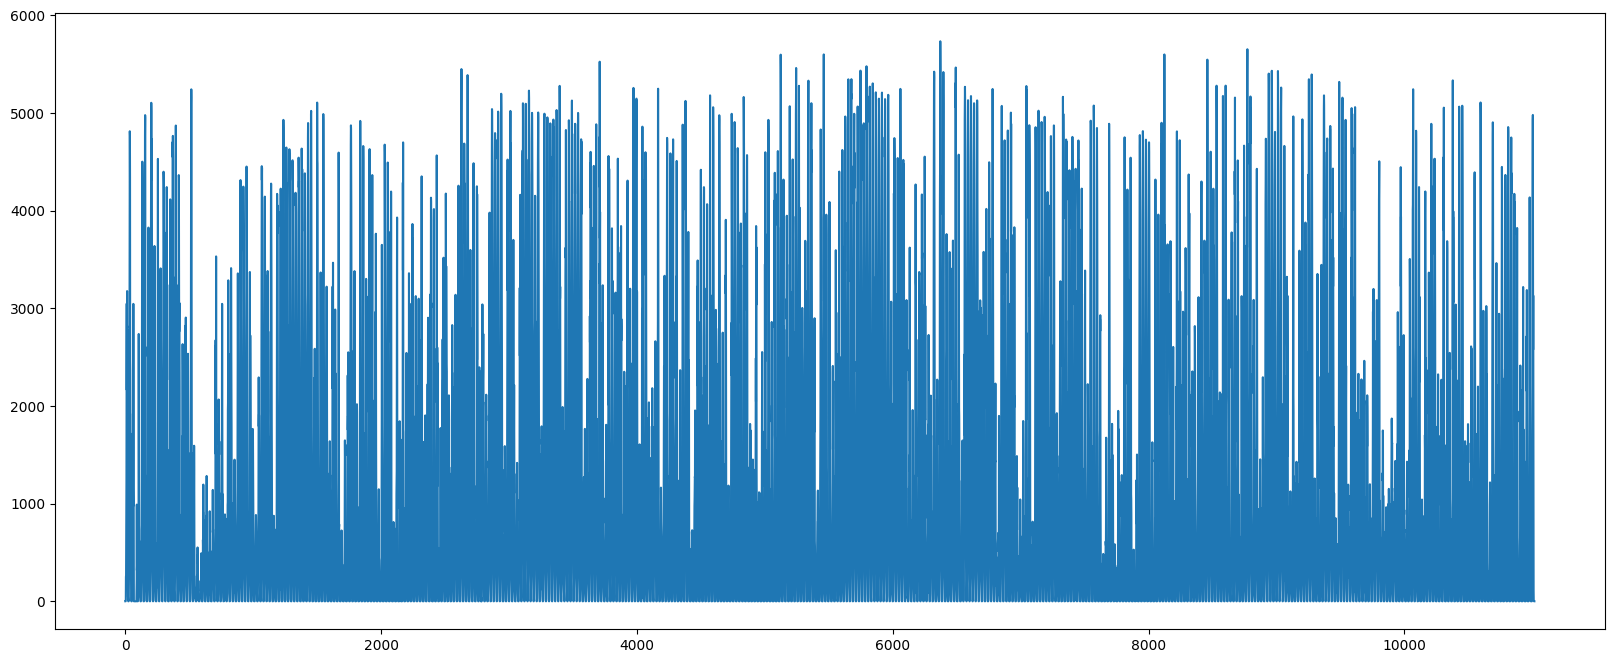

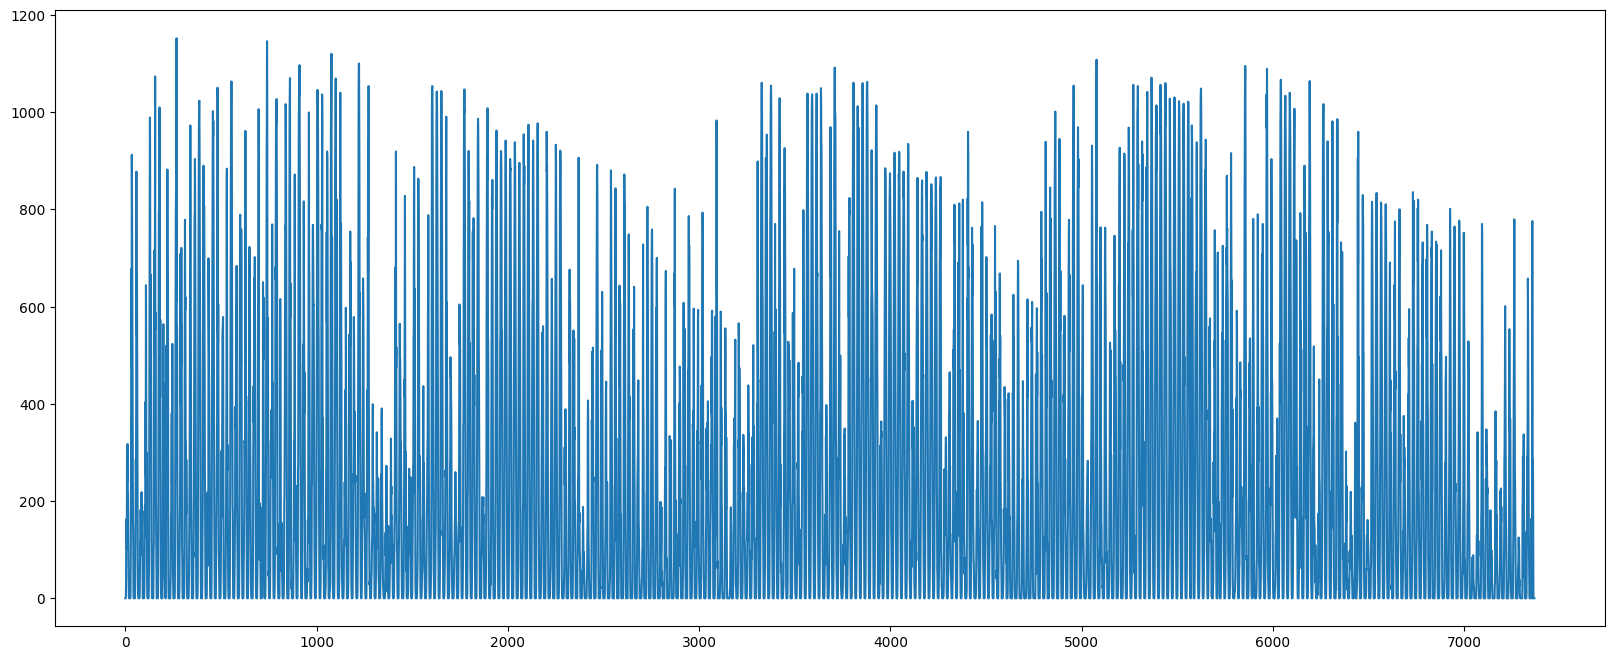

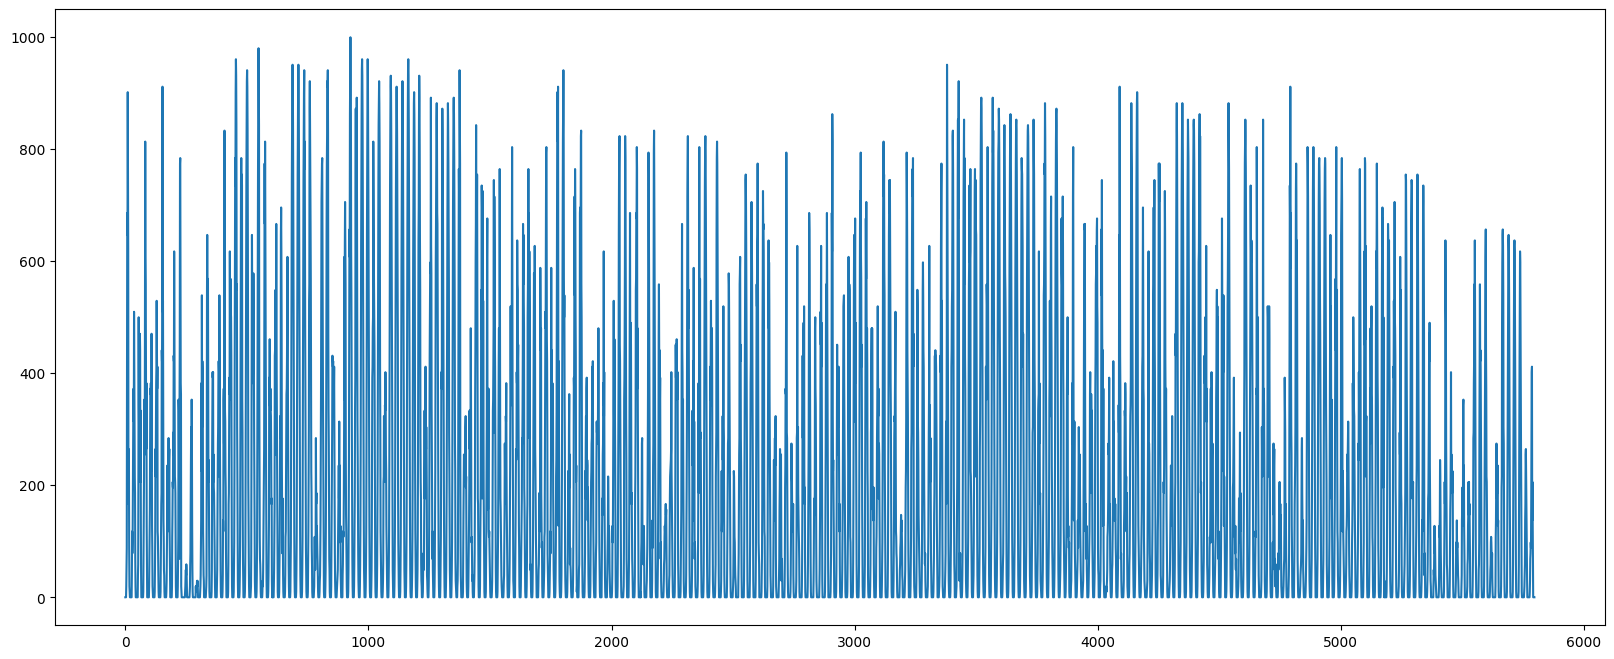

In [57]:
 
features = ["direct_rad:W", "effective_cloud_cover:p", "derivative_sun_azimuth:d_d", "sun_elevation:d", "clear_sky_rad:W", "log_diffuse_rad:W", "integral_elevation:m_integral", "filtered_freq_2_t_1000hPa:K"] + time_features

l = learner(file_paths = file_paths, features = features)
l.create_training_data()
l.fit_model()
l.get_performance()



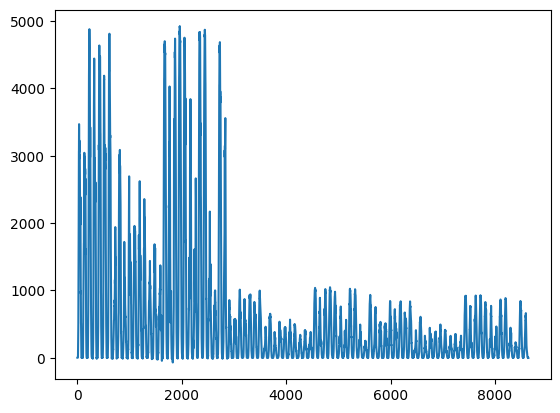

In [ ]:
l.save_best_features("dsad")
l.predict()

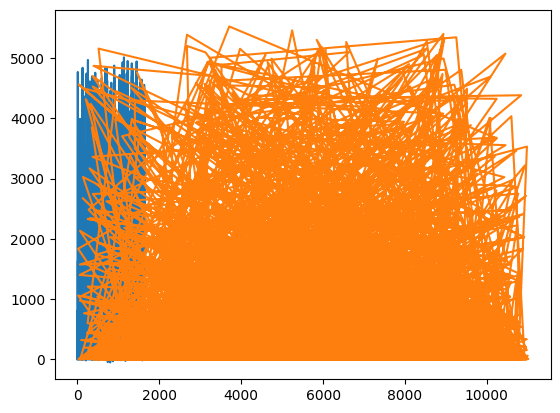

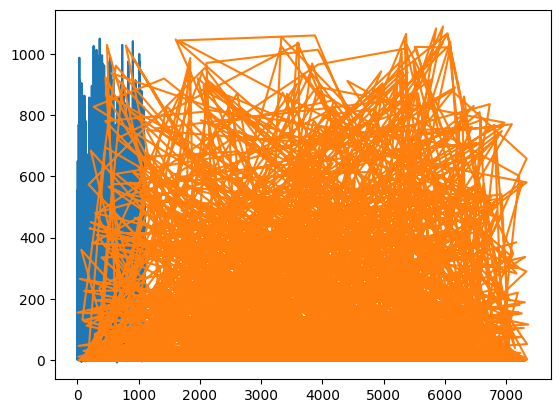

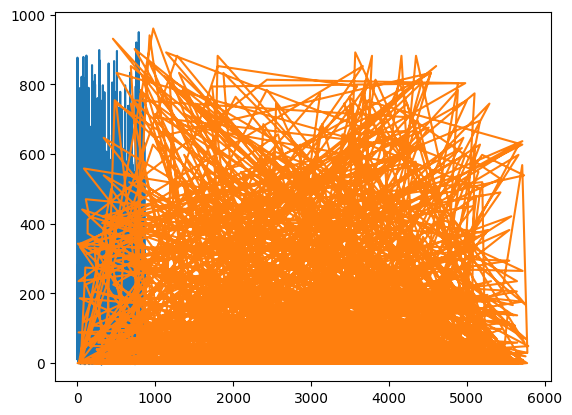

Mean absolute error:  143.275847676874


In [ ]:
multi_learner = learner(file_paths = file_paths, features = features)
multi_learner.create_training_data_multi_model()
multi_learner.fit_multi_model()
multi_learner.get_performance_multi_model()



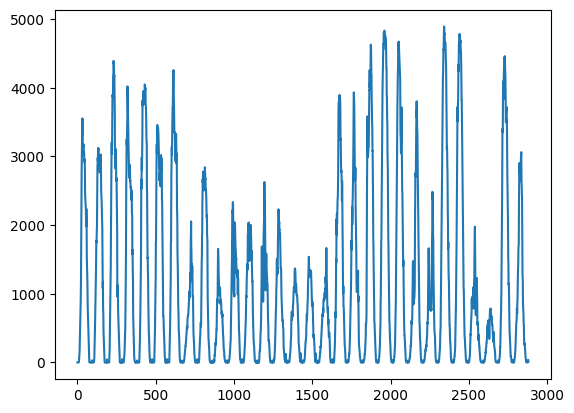

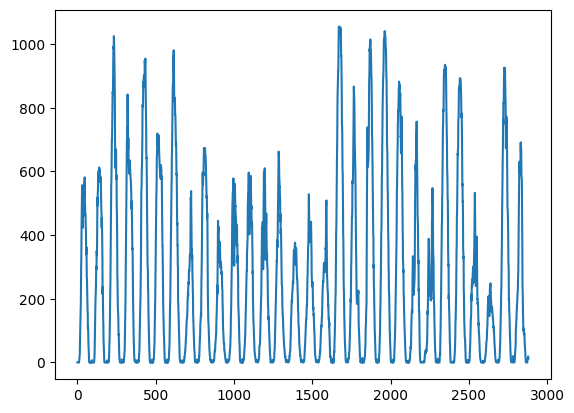

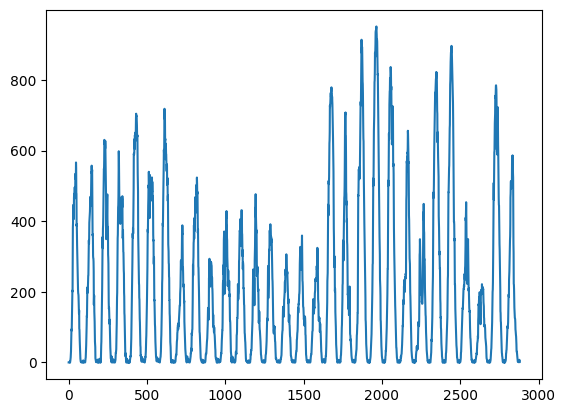

In [ ]:
multi_learner.save_best_features_multi_model("dsad")
multi_learner.predict_multi_model()